In [987]:
#Stars and stuff
from astroquery.gaia import Gaia
from astropy.io.votable import parse, parse_single_table
from astropy.timeseries import LombScargle
import pandas as pd
from astropy.coordinates import SkyCoord

#Math
import numpy as np
from scipy.linalg import lstsq
import scipy as sp
import pymc3 as pm
import theano.tensor as tt

#Machine Learning
from sklearn.model_selection import train_test_split

#Plotting
import matplotlib.pyplot as plt
from corner import corner
import matplotlib.lines as lines
import matplotlib.colors as colors

import dustmaps.sfd
dustmaps.sfd.fetch()
from dustmaps.sfd import SFDQuery

#Caching
from joblib import Memory
location = "./cachedir"
memory = Memory(location, verbose=0)

#File manipulation
from urllib.request import urlopen
import io
from glob import glob
import os
import sys

Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.
Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.


In [2]:
def get_gaia_query_rrlyrae(num_stars = 100, num_clean_epochs = 40, conds=None, verbose=False):
    add = ""
    if conds is not None:
        add = f"AND {conds}"
    query = f'''
        SELECT TOP {num_stars} *
        FROM gaiadr2.gaia_source as gaia
        JOIN gaiadr2.vari_rrlyrae using (source_id)
        WHERE
            num_clean_epochs_g > {num_clean_epochs}
    ''' + add
    if verbose:
        print(query)
    job = Gaia.launch_job_async(query)
    return job.get_results()

get_gaia_query_rrlyrae_cached = memory.cache(get_gaia_query_rrlyrae)

In [3]:
def get_gaia_query_general(query):
    job = Gaia.launch_job_async(query)
    return job.get_results()
get_gaia_query_general_cached = memory.cache(get_gaia_query_general)

In [4]:
def rmse(a, b):
    return np.sqrt(np.mean(np.square(a-b)))

In [5]:
def mse(a,b):
    return np.mean(np.square(a-b))

In [1004]:
def get_Gband(data,index=None,source_id=None, verbose=False):
    assert index!=None or source_id!=None, "Must pass in either index or source_id"
    if index!=None:
        if source_id!=None and verbose:
            print(f"Using index: {index} instead of source_id: {source_id}")
        selected_row=data[index]
        source_id=selected_row['source_id']
        if verbose:
            print(f"Analyzing star with source_id: {source_id}")
    if sys.platform=="linux":
        dirname = "lightcurve_xmls_win"
    else:
        dirname = "lightcurve_xmls_mac"
    lc_f = f"{dirname}/{source_id}.xml"
    if os.path.exists(lc_f):
        votable = parse_single_table(lc_f)
    else:
        url = selected_row['epoch_photometry_url']
        if type(url) == bytes:
            url = url.decode('utf-8')
        votable = parse(url)
        votable.format = 'binary'
        with open(lc_f, 'w') as d:
            votable.to_xml(d)
        votable = parse_single_table(lc_f)
    Gstring = "G" if sys.platform=="linux" else b'G'
    Gband = votable.array[votable.array['band'] == Gstring]
    return Gband

In [7]:
def get_maxmin_freqs(data):
    if any([type(x)==np.ma.core.MaskedConstant for x in data['pf']]):
        col_name = 'p1_o'
    else:
        col_name = 'pf'
    max_freq, min_freq = 1/np.min(data[col_name]), 1/np.max(data[col_name])
    return max_freq, min_freq

In [8]:
def estimate_period(Gband, max_freq=2.465, min_freq=1.044, p=False):
    mag = Gband['mag']
    flux = Gband['flux']
    time = Gband['time']
    flux_err = Gband['flux_error']
        
    freq, power = LombScargle(time, flux, flux_err).autopower(maximum_frequency=max_freq,
                                                              minimum_frequency=min_freq,
                                                              nyquist_factor=100)
    period = 1/freq[np.argmax(power)]
      
    phase = time % period
    if p:
        plt.figure(figsize=(8,5))
        plt.plot(freq, power, '-k')
        plt.xlabel("Frequency")
        plt.ylabel("Spectral Power")
        
        fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,5))
        
        ax1.scatter(phase, flux)
        ax1.set(xlabel="Phase", ylabel="Flux")
        ax1.grid()
        
        ax2.scatter(phase, mag)
        ax2.set(xlabel="Magnitude", ylabel="Flux")
        ax2.grid()
        
        plt.show()
        
        print(f"Estimated period: 1/{freq[np.argmax(power)]:.5f} = {period:.5f}")
#         print(f"Period as reported by vari_rrlyrae: {recorded_period:.5f}")
#         print(f"RMSE: {np.sqrt(np.mean(np.square(period - recorded_period)))}")
        
    return period

In [1017]:
def plot_magnitude(Gband, p = True):
    time = Gband['time']
    mag = Gband['mag']
    mag_uncertainty = 1.09/Gband['flux_over_error']
    if p:
        plt.figure(figsize=(8,5))
        plt.title("Magnitude w/ Magnitude Uncertainty")
        plt.fill_between(time, mag+mag_uncertainty/2,mag-mag_uncertainty/2, color='blue', alpha=0.5)
        plt.xlabel("Time")
        plt.ylabel("Magnitude")
        plt.grid()
        plt.show()
        print(f"Estimated mean: {mag_est}")
        
    mag_est = np.log(np.average(np.exp(mag)))
    return mag_est

In [10]:
def setup_fit(flux, time, omega, k):
    num_samps = len(time)
    k_s = np.arange(1,k+1)
    tk_tiling = np.outer(time, k_s)*omega
    X = np.zeros((num_samps, 2*k+1))
    X[:,0] = np.ones(num_samps)
    X[:,1:k+1] = np.sin(tk_tiling)
    X[:,k+1:] = np.cos(tk_tiling)
    return X

In [11]:
def pseudo_fourier(omega, t, A0, a, b):
    assert len(a) == len(b), f"Length of a and length of b must be the same"
    K = len(a)
    s,c = np.zeros(len(t)), np.zeros(len(t))
    for k in range(1, K+1):
        s += a[k-1]*np.sin(k*omega*t)
        c += b[k-1]*np.cos(k*omega*t)
    return A0 + s + c

In [12]:
def get_prediction(Gband, max_freq, min_freq, k, p=False):
    
    flux,time=Gband['flux'], Gband['time']
    source_id=Gband['source_id'][0]
    period=estimate_period(Gband, max_freq=max_freq, min_freq=min_freq)
    omega=2*np.pi/period
    
    X = setup_fit(flux, time, omega, k)
    beta = lstsq(X, flux.data)[0]

    A0=beta[0]
    a=beta[1:k+1]
    b=beta[k+1:]
    
    time_interp=np.arange(np.min(time), np.max(time), 1)
    f_interp = pseudo_fourier(omega=2*np.pi/period, t=time_interp, A0=A0, a=a, b=b)
    phase_interp, flux_interp = sort_by_phase(time_interp%period, f_interp)
    
    if p:
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(16,7), gridspec_kw={'height_ratios':[3,1]})
        ax1.scatter(time%period, flux, label="Original",color='black')
        ax1.scatter(time%period, X.dot(beta), label="Predicted", color='green')
        ax1.set(title=f"SourceID: {source_id}\nRMSE: {rmse(flux, X.dot(beta)):.5f}",ylabel="Flux")
        ax1.legend()
        ax1.grid()

        ax3.scatter(time%period, flux-X.dot(beta), label="Residual",color='red')
        ax3.set(xlabel="Phase")
        ax3.grid()

        ax2.scatter(time%period, flux, label="Original f")
        ax2.plot(phase_interp, flux_interp, label="Predicted f", color="red")
        ax2.set(title="Interpolated Values", xlabel="Phase",ylabel="Flux")
        ax2.legend()
        ax2.grid()

        fig.delaxes(ax4)

        plt.show()

In [13]:
def sort_by_phase(phase, x):
    sorted_phase, sorted_x = np.array(sorted(zip(phase, x), key=lambda pair: pair[0])).T
    return sorted_phase, sorted_x

# Q1

In [19]:
pf_cond = "pf IS NOT NULL"
rrlyrae_100 = get_gaia_query_rrlyrae_cached(num_stars = 100, num_clean_epochs=40, conds=pf_cond)
rrlyrae_100[:10]

<Table length=10>
    solution_id             designation          ...      source_id     
                                                 ...                    
       int64                   object            ...        int64       
------------------- ---------------------------- ... -------------------
1635721458409799680 Gaia DR2 5866125710834119808 ... 5866125710834119808
1635721458409799680 Gaia DR2 5978435871487788288 ... 5978435871487788288
1635721458409799680 Gaia DR2 5704736782734774528 ... 5704736782734774528
1635721458409799680 Gaia DR2 5816755332315333888 ... 5816755332315333888
1635721458409799680 Gaia DR2 5821611776409134976 ... 5821611776409134976
1635721458409799680 Gaia DR2 5642603243216872576 ... 5642603243216872576
1635721458409799680 Gaia DR2 5813181197970338560 ... 5813181197970338560
1635721458409799680 Gaia DR2 5630421856972980224 ... 5630421856972980224
1635721458409799680 Gaia DR2 5810405553887250432 ... 5810405553887250432
1635721458409799680 Gaia DR2 5821156028840408576 ... 5821156028840408576

# Q2

In [20]:
for row in rrlyrae_100:
    url = row['epoch_photometry_url'] if sys.platform=="linux" else row['epoch_photometry_url'].decode('utf-8')
    source_id = row['source_id']
    if sys.platform=="linux":
        dirname = "lightcurve_xmls_win"
    else:
        dirname = "lightcurve_xmls_mac"
    dest = f"{dirname}/{source_id}.xml"
    if os.path.exists(dest):
#         print("It exists!")
        continue
    votable = parse(url)
    votable.format = 'binary'
    with open(dest, 'w') as d:
        votable.to_xml(d)

# Q3/4

In [1021]:
diff = 0
all_mags_naive = []
for idx in np.arange(len(rrlyrae_100)):
    Gband = get_Gband(rrlyrae_100, idx, verbose=True)
    period = estimate_period(Gband)
    magnitude = plot_magnitude(Gband, False)
    all_mags_naive.append(magnitude)
    print(f"\t Period")
    print(f"\t\t Estimated period: {period}")
    print(f"\t\t Observed period: {rrlyrae_100['pf'][idx]}")
    print(f"\t Magnitude")
    print(f"\t\t Estimated magnitude: {magnitude}")
    diff += abs(period-rrlyrae_100['pf'][idx])
print(f"Average absolute error of estimated periods: {diff/100}")

Analyzing star with source_id: 5866125710834119808
	 Period
		 Estimated period: 0.4521051688958805
		 Observed period: 0.45207240076998667
	 Magnitude
		 Estimated magnitude: 19.946828896117868
Analyzing star with source_id: 5978435871487788288
	 Period
		 Estimated period: 0.6484169487670335
		 Observed period: 0.648442595496394
	 Magnitude
		 Estimated magnitude: 18.381831818174817
Analyzing star with source_id: 5704736782734774528
	 Period
		 Estimated period: 0.6269624075997384
		 Observed period: 0.6270046382069818
	 Magnitude
		 Estimated magnitude: 18.41666652969248
Analyzing star with source_id: 5816755332315333888
	 Period
		 Estimated period: 0.7914627967504105
		 Observed period: 0.7913965498561393
	 Magnitude
		 Estimated magnitude: 17.609506905156397
Analyzing star with source_id: 5821611776409134976
	 Period
		 Estimated period: 0.7982430364372592
		 Observed period: 0.7982343357378148
	 Magnitude
		 Estimated magnitude: 16.46357154389382
Analyzing star with source_id: 5

	 Period
		 Estimated period: 0.7621328671153655
		 Observed period: 0.7622409808789918
	 Magnitude
		 Estimated magnitude: 18.03626553576115
Analyzing star with source_id: 4941246559927578112
	 Period
		 Estimated period: 0.7942178641239133
		 Observed period: 0.7941340203512596
	 Magnitude
		 Estimated magnitude: 16.10325792673207
Analyzing star with source_id: 5018560644180206592
	 Period
		 Estimated period: 0.7828238000625215
		 Observed period: 0.7829309275292053
	 Magnitude
		 Estimated magnitude: 15.683367026171078
Analyzing star with source_id: 5276049529916719744
	 Period
		 Estimated period: 0.8227175741241375
		 Observed period: 0.8227975976977054
	 Magnitude
		 Estimated magnitude: 17.905715598882395
Analyzing star with source_id: 5027233591900665216
	 Period
		 Estimated period: 0.9255445863775434
		 Observed period: 0.9256037369212442
	 Magnitude
		 Estimated magnitude: 18.85421598340847
Analyzing star with source_id: 5047059779413535488
	 Period
		 Estimated period: 0.7

With an average absolute error of 0.00824 for 100 stars. This seems like an absolute win.

In [21]:
selected_index = 6
selected_Gband = get_Gband(rrlyrae_100, selected_index)

Analyzing star with source_id: 5813181197970338560


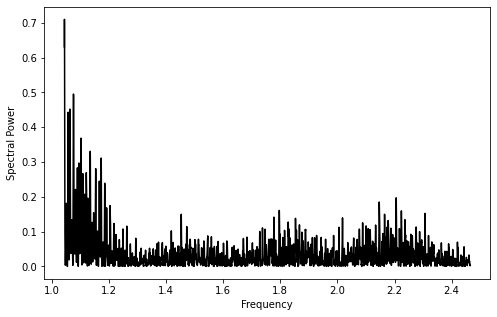

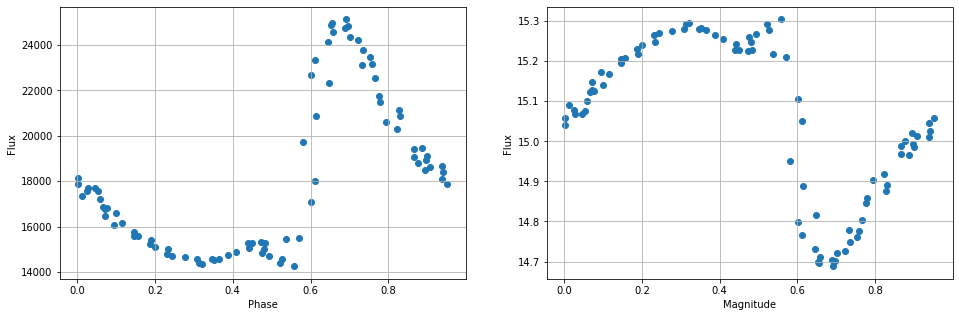

Estimated period: 1/1.04433 = 0.95756
Period as reported by vari_rrlyrae: 0.95765
RMSE: 9.488197693585665e-05


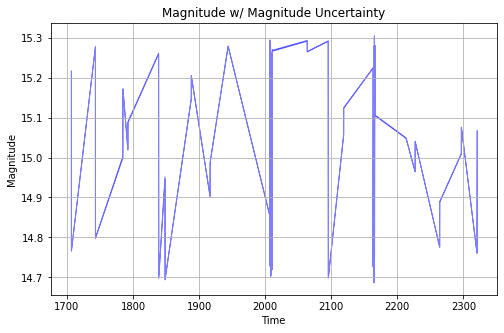

Estimated mean: 15.070074092017139


In [22]:
period = estimate_period(selected_Gband, p=True)
recorded_period = rrlyrae_100['pf'][selected_index]
print(f"Period as reported by vari_rrlyrae: {recorded_period:.5f}")
print(f"RMSE: {np.sqrt(np.mean(np.square(period - recorded_period)))}")
plot_magnitude(selected_Gband)

# Q5

![Matrix](q5.jpg)

# Q6

Analyzing fit for k=1...


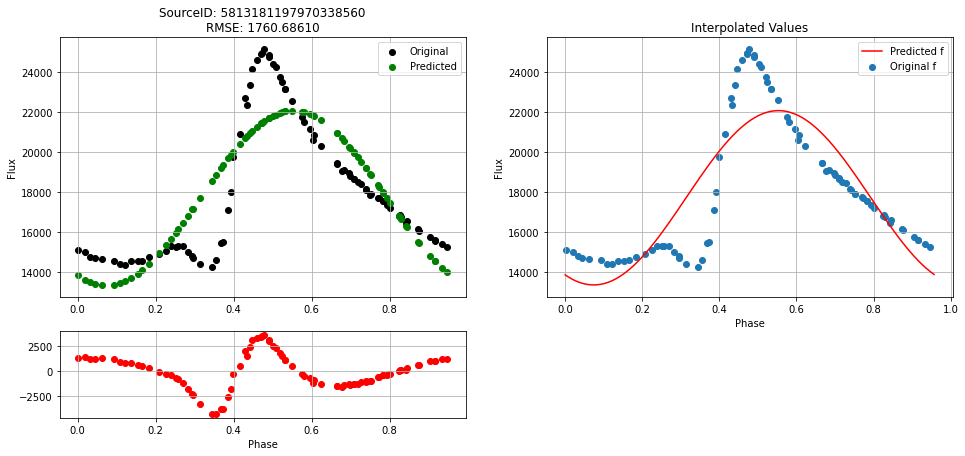

Analyzing fit for k=3...


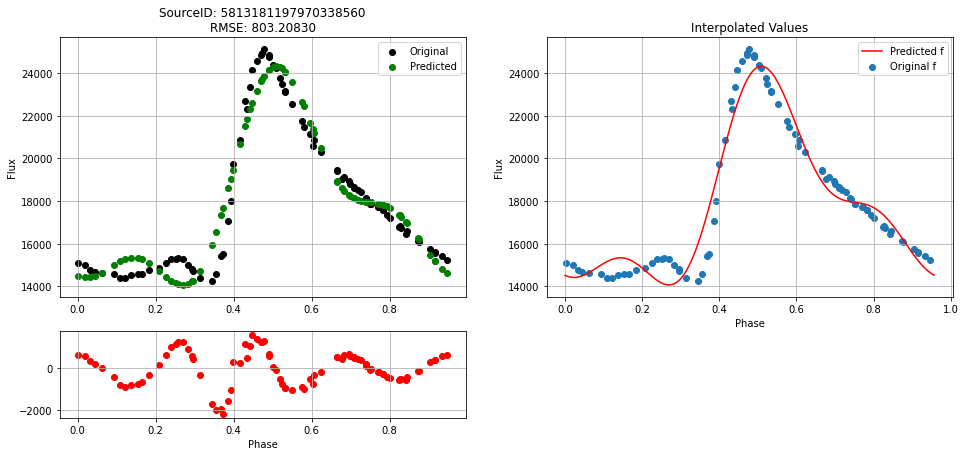

Analyzing fit for k=5...


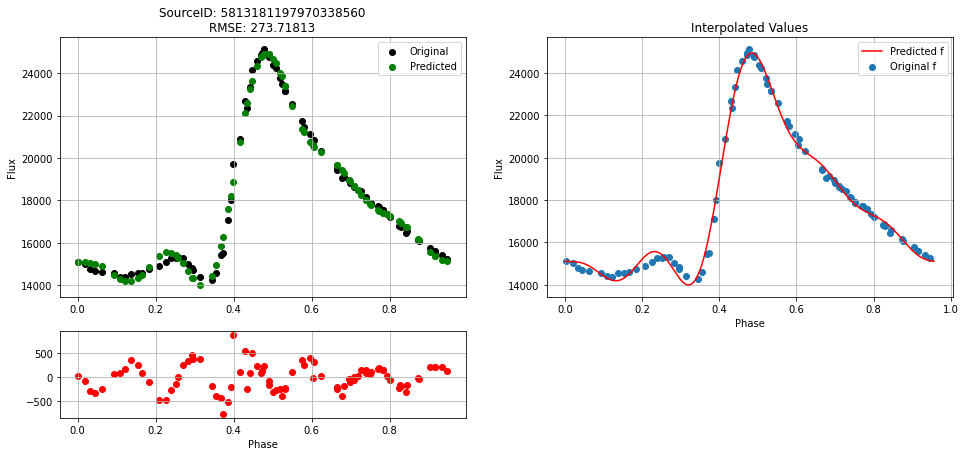

Analyzing fit for k=7...


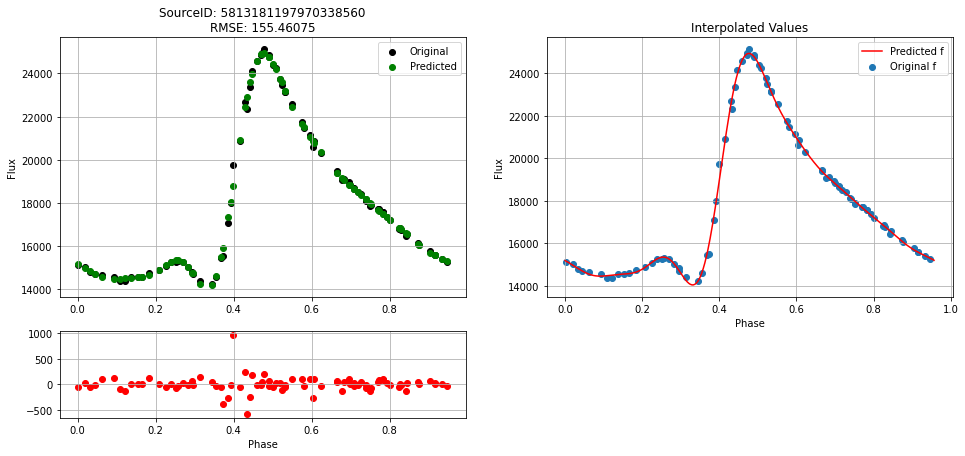

Analyzing fit for k=9...


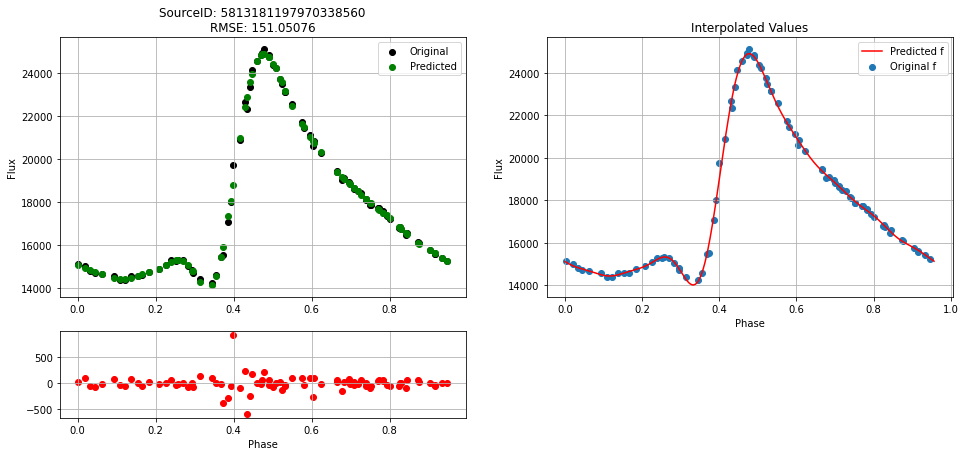

In [23]:
k_vals = [1,3,5,7,9]
max_freq, min_freq = get_maxmin_freqs(rrlyrae_100)
for k in k_vals:
    print(f"Analyzing fit for k={k}...")

    get_prediction(selected_Gband, max_freq=max_freq, min_freq=min_freq, k=k, p=True)
    

# Q7

In [24]:
k_vals = np.arange(1,25+1)
train_mses = np.zeros(len(k_vals))
test_mses = np.zeros(len(k_vals))
time = selected_Gband['time']
flux = selected_Gband['flux']
period=estimate_period(selected_Gband)
omega=2*np.pi/period
time_train, time_test, flux_train, flux_test = train_test_split(time, flux, test_size=0.2)

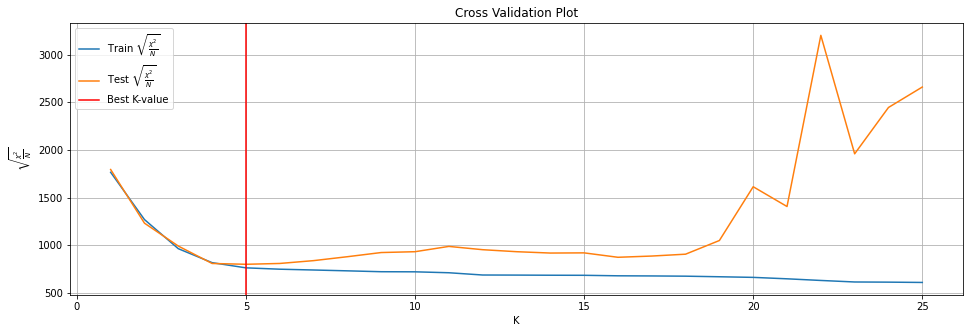

In [25]:
p = False
for i,k in enumerate(k_vals):
#     print(f"Analyzing fit for k={k}...")

    X = setup_fit(flux_train, time_train, omega, k)
    beta_train = lstsq(X, flux_train.data)[0]
    A0=beta_train[0]
    a=beta_train[1:k+1]
    b=beta_train[k+1:]
    pred_train = pseudo_fourier(omega, time_train, A0, a, b)
    pred_test = pseudo_fourier(omega, time_test, A0, a, b)
    
    train_mse = rmse(flux_train, pred_train)
    train_mses[i] = train_mse
    
    test_mse = rmse(flux_test, pred_test)
    test_mses[i] = test_mse
    
    if p and k >= 20:
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))
        ax1.scatter(time_train%period,flux_train, label="Truth")
        ax1.scatter(time_train%period,pred_train,label="Pred")
        ax1.set(title=f"K={k}: $\\frac{{\\chi^2}}{{N}} = {train_mse:.3f}$")
        ax1.legend()

        ax2.scatter(time_test%period,flux_test, label="Truth")
        ax2.scatter(time_test%period,pred_test,label="Pred")
        ax2.set(title=f"$\\frac{{\\chi^2}}{{N}} = {test_mse:.3f}$")
        ax2.legend()
        plt.show()
        
# print(test_mses)
fig,ax = plt.subplots(figsize=(16,5))
ax.plot(k_vals, train_mses, label="Train $\\sqrt{{\\frac{{\\chi^2}}{{N}}}}$")
ax.plot(k_vals, test_mses, label="Test $\\sqrt{{\\frac{{\\chi^2}}{{N}}}}$")
ax.axvline(np.argmin(test_mses)+1,color='red', label="Best K-value")
ax.legend()
ax.grid()
ax.set(xlabel="K", ylabel="$\\sqrt{{\\frac{{\\chi^2}}{{N}}}}$", title="Cross Validation Plot")
plt.show()

As you can see from the cross-validation, the pseudo-fourier representation of the data quickly overfits to our fairly simple data. Therefore a smaller number of sin and cosin functions are necessary at around $k=6$

# Q8

17707.83890462764 2320.202939518489


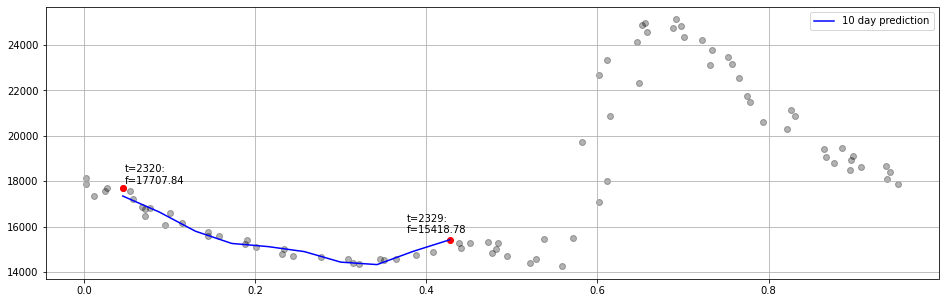

In [26]:
k_best = np.argmin(test_mses)+1
X = setup_fit(flux, time, omega, k_best)
beta_best = lstsq(X, flux.data)[0]
A0_best=beta_best[0]
a_best=beta_best[1:k_best+1]
b_best=beta_best[k_best+1:]
last_flux, last_time = flux[-1], time[-1]
print(last_flux, last_time)
final_time = last_time+10
time_extrap = np.arange(last_time, final_time)
pred_extrap = pseudo_fourier(omega, time_extrap, A0_best, a_best, b_best)
phase_extrap, flux_extrap = sort_by_phase(time_extrap%period, pred_extrap)
fig,ax = plt.subplots(figsize=(16,5))
ax.scatter(time%period, flux,color='black', alpha=0.3)
ax.scatter(last_time%period, last_flux,color='red')
ax.annotate(f"t={last_time:.0f}:\nf={last_flux:.2f}", (last_time%period+0.002, last_flux+200))
ax.plot(phase_extrap, flux_extrap, color='blue', label="10 day prediction")
ax.scatter(phase_extrap[-1], flux_extrap[-1],color='red')
ax.annotate(f"t={time_extrap[-1]:.0f}:\nf={flux_extrap[-1]:.2f}", (phase_extrap[-1]-0.05, flux_extrap[-1]+300))
ax.grid()
ax.legend()
plt.show()

# Q9

In [1019]:
all_mags = []
for idx in np.arange(len(rrlyrae_100)):
    row = rrlyrae_100[idx]
    Gband = get_Gband(rrlyrae_100, idx)
    period = row['pf']
    mag = Gband['mag']
    X = setup_fit(_, Gband['time'], 2*np.pi/period, k_best)
    beta_best = lstsq(X, mag.data)[0]
    A0_best=beta_best[0]
    a_best=beta_best[1:k_best+1]
    b_best=beta_best[k_best+1:]
    time_eval = np.linspace(period, 2*period, 500)
    mags = pseudo_fourier(2*np.pi/period, time_eval, A0_best, a_best, b_best)
    all_mags.append(np.mean(np.log(np.exp(mags))))
    

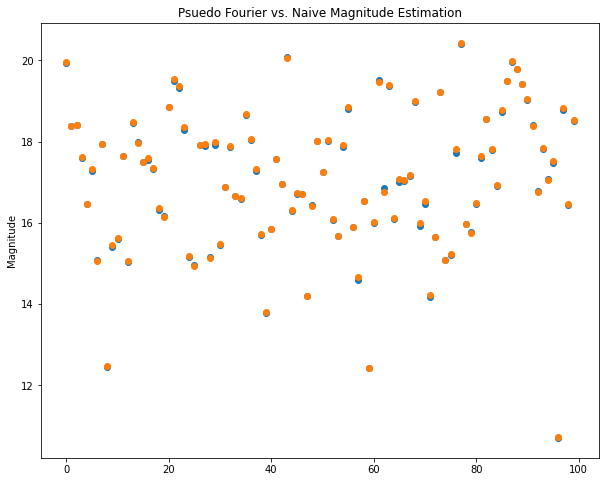

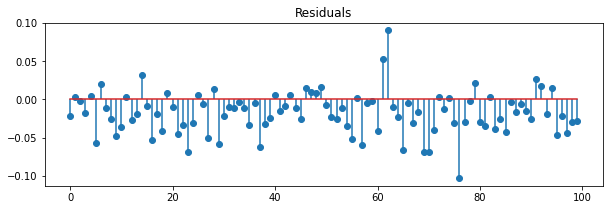

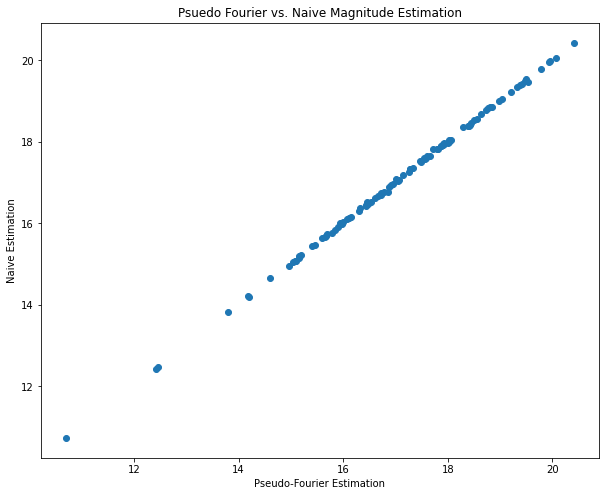

In [1025]:
plt.figure(figsize=(10,8))
plt.title("Psuedo Fourier vs. Naive Magnitude Estimation")
plt.scatter(range(100), all_mags, label = "Pseudo-Fourier Estimation")
plt.scatter(range(100), all_mags_naive, label = "Naive")
plt.ylabel("Magnitude")
plt.show()
plt.figure(figsize=(10,3))
plt.title("Residuals")
plt.stem(np.array(all_mags) - np.array(all_mags_naive))
plt.show()

plt.figure(figsize=(10,8))
plt.title("Psuedo Fourier vs. Naive Magnitude Estimation")
plt.scatter(all_mags, all_mags_naive)
plt.ylabel("Naive Estimation")
plt.xlabel("Pseudo-Fourier Estimation")
plt.show()

In theory, using the Pseudo-Fourier method should be better than the naive estimation, however according to the plot, they are ver similar.

# Q10

In [27]:
rrc_conds = f"""
best_classification='RRc'
AND int_average_g > 15
"""
rrlyrae_rrc = get_gaia_query_rrlyrae_cached(num_stars = 3, num_clean_epochs=80, conds=rrc_conds)
rrlyrae_rrc

<Table length=3>
    solution_id             designation          ...      source_id     
                                                 ...                    
       int64                   object            ...        int64       
------------------- ---------------------------- ... -------------------
1635721458409799680 Gaia DR2 4659714065019384064 ... 4659714065019384064
1635721458409799680  Gaia DR2 413458020354821504 ...  413458020354821504
1635721458409799680 Gaia DR2 5438044842945235712 ... 5438044842945235712

In [28]:
rrc_Gbands = [get_Gband(rrlyrae_rrc, i) for i, row in enumerate(rrlyrae_rrc)]

Analyzing star with source_id: 4659714065019384064
Analyzing star with source_id: 413458020354821504
Analyzing star with source_id: 5438044842945235712


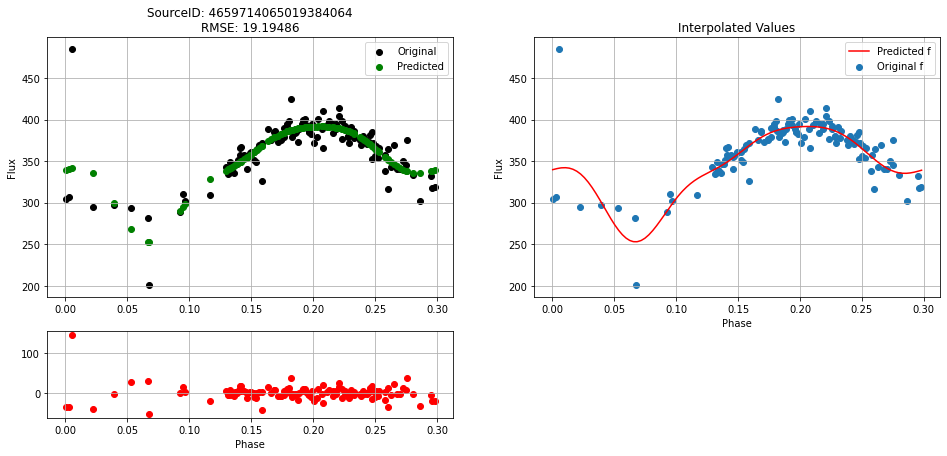

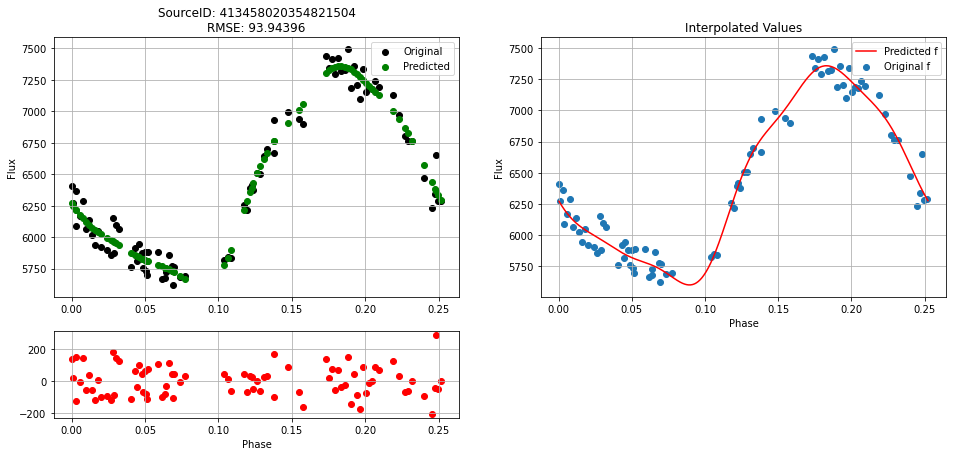

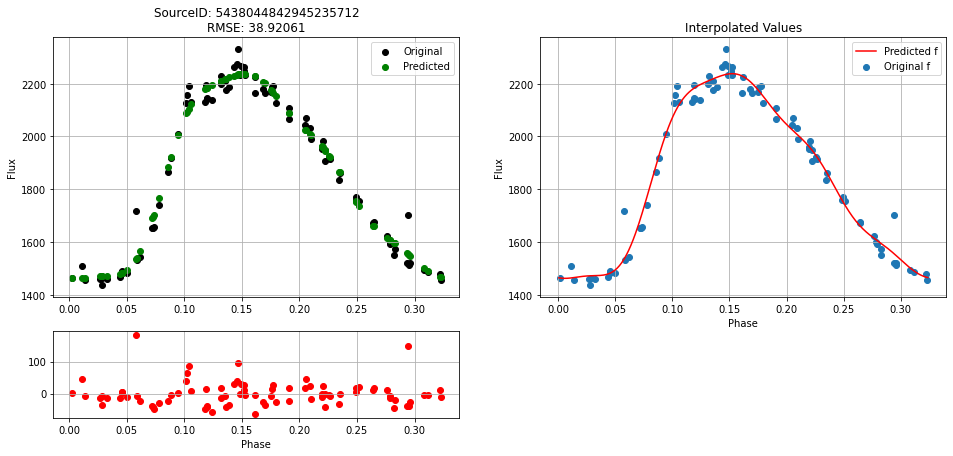

In [29]:
max_freq, min_freq = get_maxmin_freqs(rrlyrae_rrc)
for Gband in rrc_Gbands:
    get_prediction(Gband,max_freq=max_freq, min_freq=min_freq, k=k_best, p=True)

In [30]:
rrab_conds = f"""
best_classification='RRab'
AND int_average_g > 15
"""
rrlyrae_rrab = get_gaia_query_rrlyrae_cached(num_stars = 3, num_clean_epochs=80, conds=rrab_conds)
rrlyrae_rrab

<Table length=3>
    solution_id             designation          ...      source_id     
                                                 ...                    
       int64                   object            ...        int64       
------------------- ---------------------------- ... -------------------
1635721458409799680 Gaia DR2 5813181197970338560 ... 5813181197970338560
1635721458409799680 Gaia DR2 6063363425261644544 ... 6063363425261644544
1635721458409799680  Gaia DR2 418053081298938496 ...  418053081298938496

In [31]:
rrab_Gbands = [get_Gband(rrlyrae_rrab, i) for i, row in enumerate(rrlyrae_rrab)]

Analyzing star with source_id: 5813181197970338560
Analyzing star with source_id: 6063363425261644544
Analyzing star with source_id: 418053081298938496


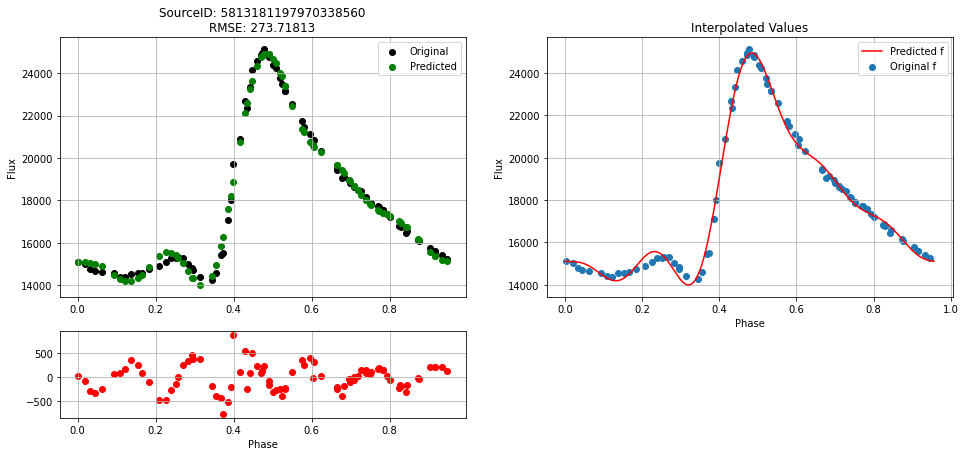

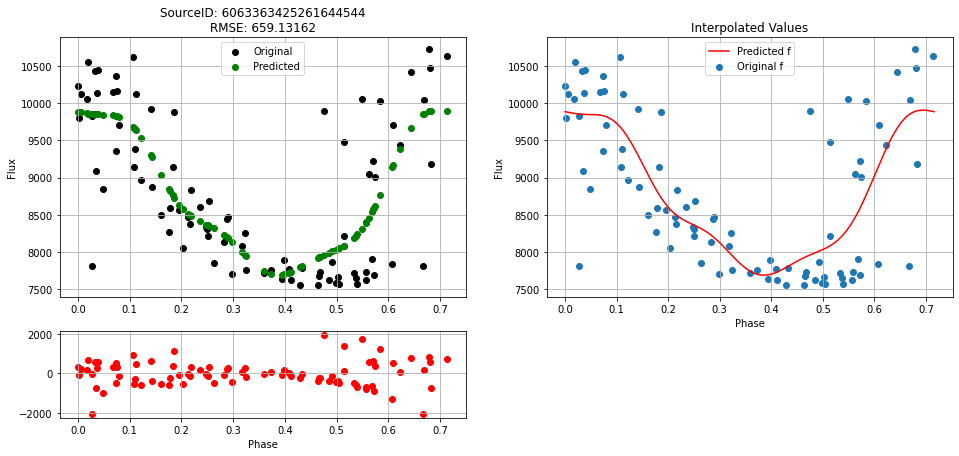

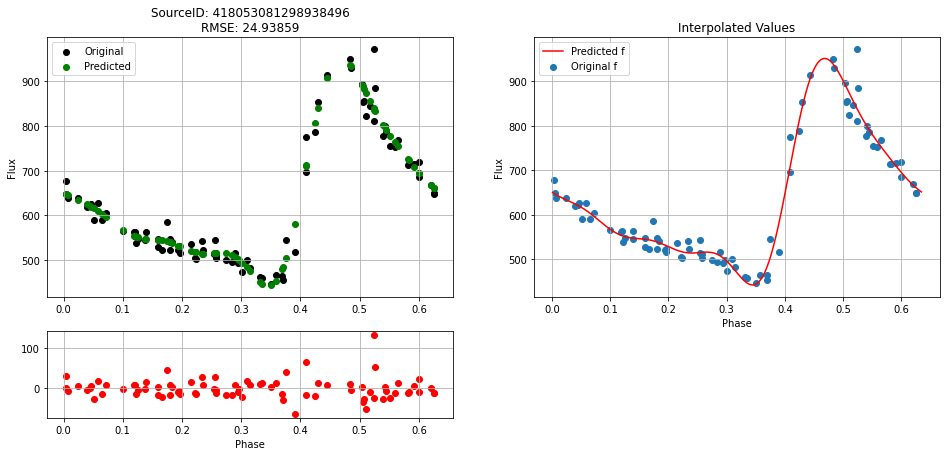

In [32]:
max_freq, min_freq = get_maxmin_freqs(rrlyrae_rrab)
for Gband in rrab_Gbands:
    get_prediction(Gband, max_freq=max_freq, min_freq=min_freq, k=k_best, p=True)

# Q11

Netzel et al. 2018 describes something called the Blazhko effect where some RR Lyrae stars have multiple frequency/periods that are in conflict. Let's take a look at the frequency power of the second star whose source_id is 6063363425261644544.

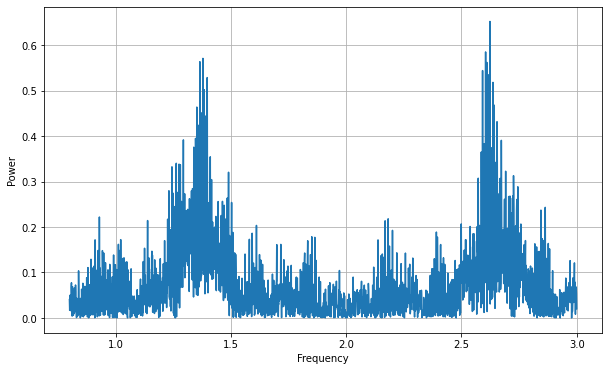

In [1027]:
sus_star = get_Gband(rrlyrae_100, source_id = 6063363425261644544)
freq= np.linspace(0.8, 3.0, num=2000)
power = LombScargle(sus_star['time'], sus_star['mag'], 1.09 / sus_star['flux_over_error']).power(freq)
plt.figure(figsize = (10, 6))
plt.plot(freq, power)
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.grid()
plt.show()

Looking at the power spectrum of this star, we see that it has two peak, one at about 1.4 and one at about 2.6. These frequency values are not multiples of each other nor do they have a shared root frequency. It seems like these two stars fall under the category of the Blazhko effect from the aforementioned paper.

While most of the 6 stars we plotted earlier seem to have well-defined single periods, this one is not so accomodating.

# Q12

In [367]:
query = """
    SELECT *
    FROM gaiaedr3.gaia_source as gaia3
    JOIN gaiaedr3.dr2_neighbourhood as link
        ON gaia3.source_id = link.dr3_source_id
    JOIN gaiadr2.vari_rrlyrae as rrlyrae
        ON rrlyrae.source_id = gaia3.source_id
    WHERE
        parallax_over_error > 5
        AND abs(b) > 30
        AND parallax > 0.25 --dist < 4kpc
        AND pf IS NOT NULL
"""
rrlyrae_gaia3 = get_gaia_query_general_cached(query)
print(f"Got {len(rrlyrae_gaia3)} stars")

INFO: Query finished. [astroquery.utils.tap.core]
Got 517 stars


In [247]:
query = """
    SELECT *
    FROM gaiadr2.gaia_source as gaia2
    JOIN gaiaedr3.dr2_neighbourhood as link
        ON gaia2.source_id = link.dr2_source_id
    JOIN gaiadr2.vari_rrlyrae as rrlyrae
        ON rrlyrae.source_id = gaia2.source_id
    WHERE
        parallax_over_error > 5
        AND abs(b) > 30
        AND parallax > 0.25 --dist < 4kpc
        AND pf IS NOT NULL
"""
rrlyrae_gaia2 = get_gaia_query_general_cached(query)
print(f"Got {len(rrlyrae_gaia2)} stars")

Got 518 stars


In [370]:
gaia3_data = rrlyrae_gaia3.to_pandas()
gaia2_data = rrlyrae_gaia2.to_pandas()
gaia3_masked = gaia3_data.loc[gaia3_data['source_id'].isin(np.array(rrlyrae_gaia2['dr3_source_id']))].drop_duplicates(subset='source_id')
mask2 = gaia2_data['source_id'].isin(np.array(gaia3_masked['dr2_source_id']))
gaia2_masked = gaia2_data.loc[mask2].drop_duplicates(subset='source_id')
mask3 = gaia3_data['source_id'].isin(np.array(gaia2_masked['dr3_source_id']))
gaia3_masked = gaia3_data.loc[mask3].drop_duplicates(subset='source_id')
mask4 = gaia2_data['source_id'].isin(np.array(gaia3_masked['dr2_source_id']))
gaia2_masked = gaia2_data.loc[mask4].drop_duplicates(subset='source_id')
gaia3_sorted = gaia3_masked.sort_values('source_id')
gaia2_sorted = gaia2_masked.sort_values('source_id')
final_mask = np.array(gaia3_sorted['source_id']) == np.array(gaia2_sorted['source_id'])
gaia3_final = gaia3_sorted[final_mask]
gaia2_final = gaia2_sorted[final_mask]
print(f"DR3 Original Length: {len(gaia3_data)}")
print(f"DR2 Original Length: {len(gaia2_data)}")
print(f"Number of stars with BOTH DR3 and DR2 source_id: {len(gaia2_final)}")

DR3 Original Length: 517
DR2 Original Length: 518
Number of stars with BOTH DR3 and DR2 source_id: 351


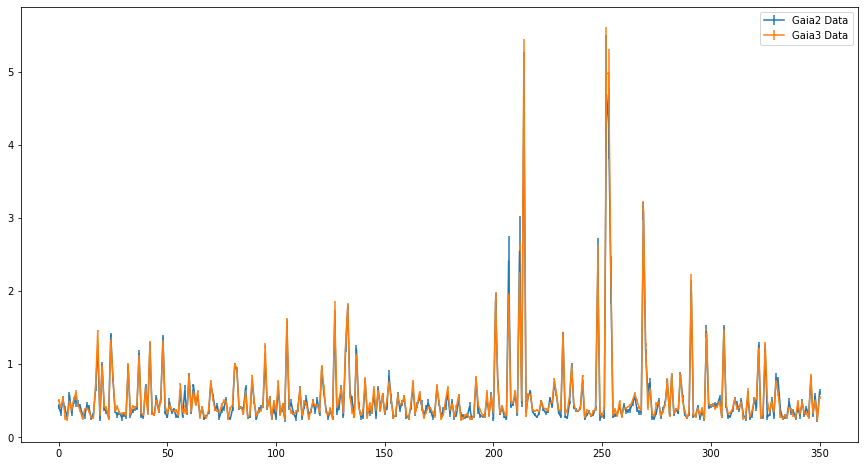

In [371]:

plt.figure(figsize=(15,8))
n = len(gaia2_final)
plt.errorbar(np.arange(n), gaia2_final["parallax"], yerr=gaia2_final["parallax_error"], label="Gaia2 Data")
plt.errorbar(np.arange(n), gaia3_final["parallax"], yerr=gaia3_final["parallax_error"], label="Gaia3 Data")
plt.legend()
plt.show()

In [372]:
diff = np.mean(gaia3_final['parallax'] - gaia2_final['parallax'])
print(f"The average difference between DR3 and DR2 parallaxes is {diff}")

The average difference between DR3 and DR2 parallaxes is 0.02481883183862426


In [1030]:
error_diff = np.mean(gaia3_final['parallax_error'] - gaia2_final['parallax_error'])
print(f"The difference between DR3 and DR2 parallax errors is {error_diff}")

The difference between DR3 and DR2 parallax errors is -0.014797497088743217


As mentioned in Torra et al. 2020, there are a number of reasons why source IDs for stars might change. One primary example that is highlighted is that certain errors in data collection are unavoidable with such a massive amount of stars to keep track of. Where at first, 2 stars were being detected, it may come to light that these two stars with unique source IDs actually are just a single star or vice versa. This is why in the above code, we had to account for duplicates to get the above graph.

# Q13

In [373]:
query="""
SELECT *
FROM gaiaedr3.gaia_source as gaia3
JOIN gaiaedr3.dr2_neighbourhood as gaia2
    ON gaia2.dr3_source_id = gaia3.source_id
JOIN gaiadr2.vari_rrlyrae as rrlyrae
    ON gaia2.dr2_source_id = rrlyrae.source_id
JOIN external.gaiaedr3_distance as dists
    ON gaia3.source_id = dists.source_id
WHERE
    abs(b)>30
    AND parallax>0.25
    AND parallax_over_error>5
    AND pf IS NOT NULL
"""
rrlyrae_gaia3_dists = get_gaia_query_general_cached(query)
print(f"Got {len(rrlyrae_gaia3_dists)} stars")
rrlyrae_gaia3_dists[:10]

Got 548 stars


<Table length=10>
    solution_id              designation          ... r_hi_photogeo  flag 
                                                  ...       pc            
       int64                    object            ...    float32    object
------------------- ----------------------------- ... ------------- ------
1636042515805110273 Gaia EDR3 4657904848780392832 ...     373.80063  10112
1636042515805110273 Gaia EDR3 4798586678570579072 ...     790.07794  10033
1636042515805110273 Gaia EDR3 4685757887726594816 ...     2942.6038  10023
1636042515805110273 Gaia EDR3 4689637956899105792 ...     2066.8225  10033
1636042515805110273 Gaia EDR3 4689637961175354240 ...            --  10099
1636042515805110273 Gaia EDR3 4700326863447344768 ...     199.95909  10033
1636042515805110273 Gaia EDR3 4690886594062571008 ...            --  10099
1636042515805110273 Gaia EDR3 4658012051209225984 ...     636.27026  10020
1636042515805110273 Gaia EDR3 4658145092114070144 ...     1112.5431  10002
1636042515805110273 Gaia EDR3 4685834544315524224 ...      360.7717  10123

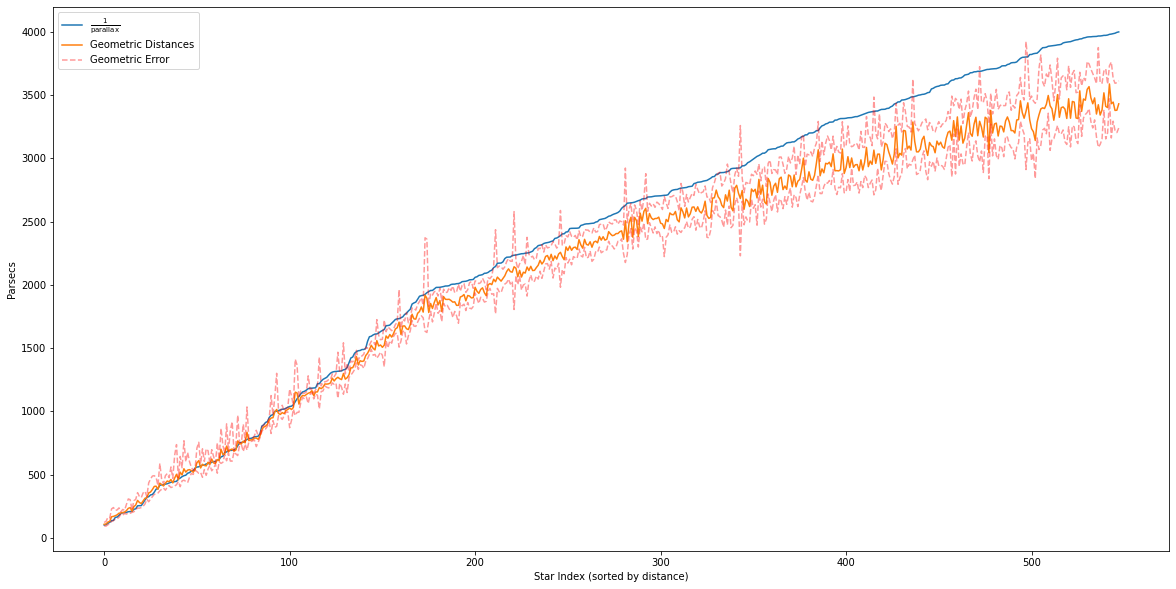

In [374]:
rrlyrae_gaia3_dists_df = rrlyrae_gaia3_dists.to_pandas()
dists = rrlyrae_gaia3_dists_df[["r_med_geo", "r_hi_geo", "r_lo_geo", 'parallax']].sort_values('parallax', ascending=False)
n = np.arange(dists.shape[0])
plt.figure(figsize=(20,10))
plt.plot(n,1000/dists["parallax"], label=r"$\frac{1}{\mathrm{parallax}}$") 
plt.plot(n, dists["r_med_geo"], label="Geometric Distances")
plt.plot(n, dists["r_hi_geo"], "--", color="red", alpha=0.4, label="Geometric Error")
plt.plot(n, dists["r_lo_geo"], "--", color="red", alpha=0.4) 
plt.ylabel("Parsecs")
plt.xlabel("Star Index (sorted by distance)")
plt.legend()
plt.show()

While the Bailer-Jones estimated distance follows the GAIA estimated parallaxes distance for closer stars, the two estimates diverge for stars that are further away. The important difference between these two estimates is that the geometric distances created by Bailer-Jones includes much more information including the stars' colours and magnitudes. 

# Q14

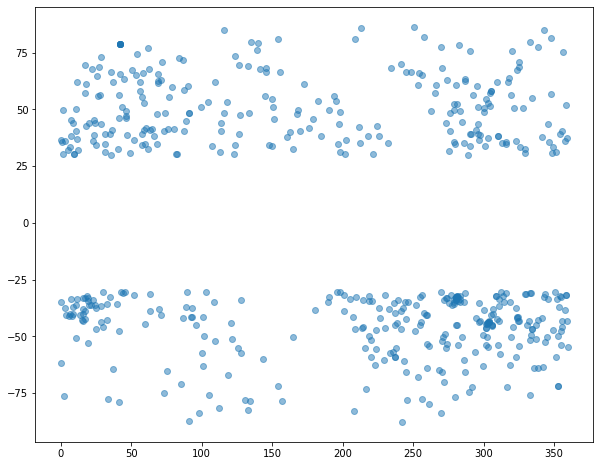

In [376]:
plt.figure(figsize=(10,8))
plt.scatter(rrlyrae_gaia3_dists['l'], rrlyrae_gaia3_dists['b'], alpha = 0.5)

From the analysis back in Q12, the DR3 errors are smaller than the DR2 errors by approximately 0.01479. The DR2 and DR3 uncertainties are generally consistent within their respective uncertainties. As described in Brown et al. 2020, the parallax uncertainties change from DR2 to DR3 because there was a much better treatment of high proper motion stars at the source list creation stage. Furthermore, this led to a much more reliable sample of high proper motion stars.

# Q15

[]

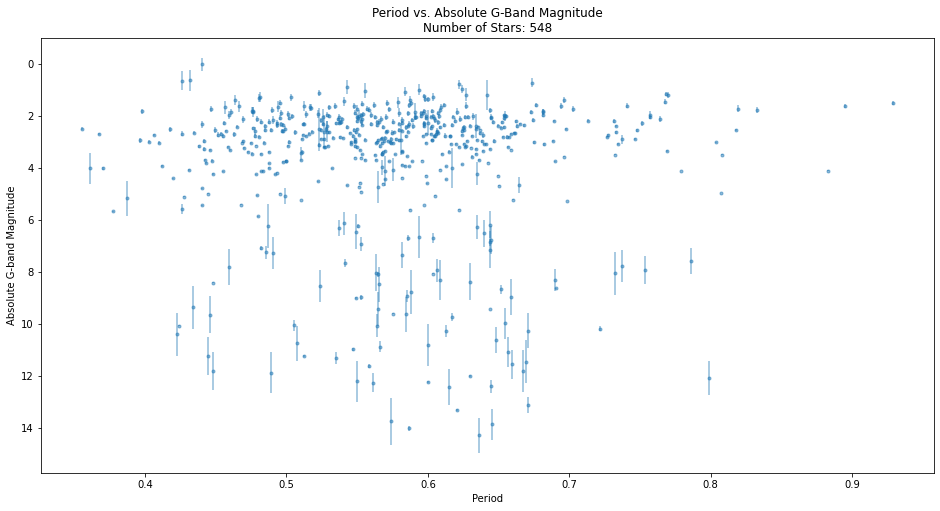

In [431]:
phot_g_mean_mag = rrlyrae_gaia3_dists["phot_g_mean_mag"]
r_hi_geo = rrlyrae_gaia3_dists["r_hi_geo"]
r_lo_geo = rrlyrae_gaia3_dists["r_lo_geo"]
parallax_over_error = rrlyrae_gaia3_dists["parallax_over_error"]
phot_g_mean_flux_over_error = rrlyrae_gaia3_dists["phot_g_mean_flux_over_error"]
Mg = phot_g_mean_mag -5*np.log10((r_hi_geo-r_lo_geo)/2)
Mg_error = np.sqrt(np.power(1.09/phot_g_mean_flux_over_error, 2)) + np.power(5/parallax_over_error/1.09, 2)
gaia3_dists_df = rrlyrae_gaia3_dists.to_pandas()
gaia3_dists_df = gaia3_dists_df.assign(Mg = Mg, Mg_error = Mg_error)

plt.figure(figsize=(16,8))
plt.errorbar(gaia3_dists_df["pf"], gaia3_dists_df['Mg'], yerr=gaia3_dists_df['Mg_error'], alpha=0.5, fmt=".")
plt.ylim(plt.ylim()[::-1])
plt.xlabel("Period")
plt.ylabel("Absolute G-band Magnitude")
plt.title(f"Period vs. Absolute G-Band Magnitude\nNumber of Stars: {len(gaia3_dists_df)}")
plt.plot()

# Q16

**(C.1):**   $u < 1.2*max(1, exp(-0.2*(G-19.5)))$

**(C.2):**   $1.0 + 0.015*(G_{BP} - G_{RP})^2 < E < 1.3+0.06*(G_{BP}-G_{RP})^2$

[]

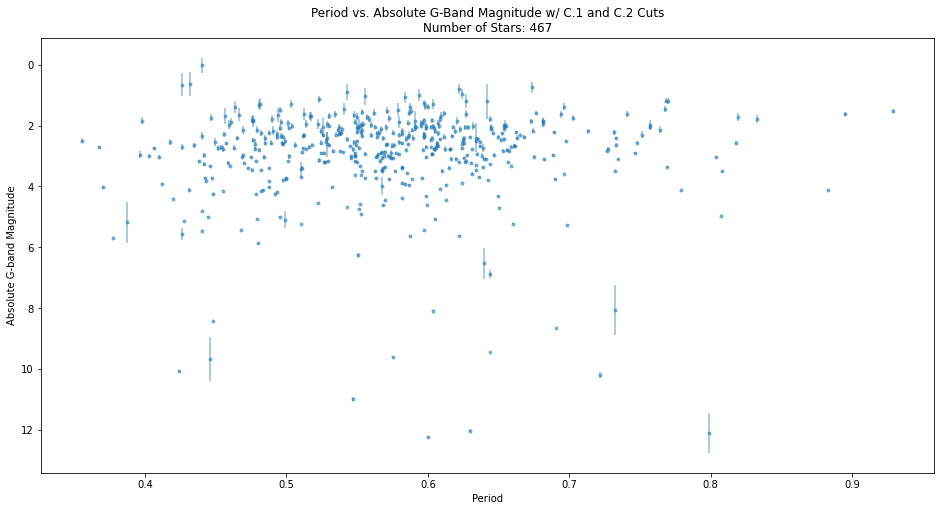

In [433]:
u = np.sqrt(gaia3_dists_df['astrometric_chi2_al'] / (gaia3_dists_df['astrometric_n_good_obs_al'] - 5))
c1_rhs = 1.2*np.maximum(1, np.exp(-0.2*(gaia3_dists_df['Mg_error'] - 19.5)))
c1_mask = u < c1_rhs

c2_lhs = 1.0 + 0.015 * gaia3_dists_df['bp_rp']**2
c2_rhs = 1.3 + 0.06 * gaia3_dists_df['bp_rp']**2
e = gaia3_dists_df['phot_bp_rp_excess_factor']
c2_mask = (c2_lhs < e) & (c2_rhs > e)

gaia3_c1c2 = gaia3_dists_df[c1_mask & c2_mask]

plt.figure(figsize=(16,8))
plt.errorbar(gaia3_c1c2["pf"], gaia3_c1c2['Mg'], yerr=gaia3_c1c2['Mg_error'], alpha=0.5, fmt=".")
plt.ylim(plt.ylim()[::-1])
plt.xlabel("Period")
plt.ylabel("Absolute G-band Magnitude")
plt.title(f"Period vs. Absolute G-Band Magnitude w/ C.1 and C.2 Cuts\nNumber of Stars: {len(gaia3_c1c2)}")
plt.plot()

While the full range of absolute G-band magnitude did not decrease, the overall standard deviation of the stars certainly has as many of the outliers were rejected.

# Q17

[]

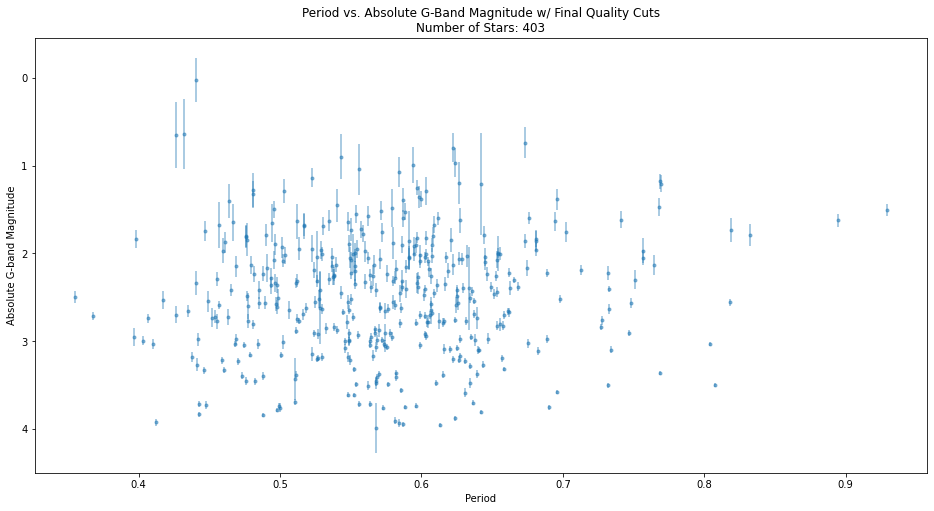

In [432]:
thresh_mask = (gaia3_c1c2['Mg']<4) & (gaia3_c1c2['Mg']>0)
gaia3_qc = gaia3_c1c2[thresh_mask]
plt.figure(figsize=(16,8))
plt.errorbar(gaia3_qc["pf"], gaia3_qc['Mg'], yerr=gaia3_qc['Mg_error'], alpha=0.5, fmt=".")
plt.ylim(plt.ylim()[::-1])
plt.xlabel("Period")
plt.ylabel("Absolute G-band Magnitude")
plt.title(f"Period vs. Absolute G-Band Magnitude w/ Final Quality Cuts\nNumber of Stars: {len(gaia3_qc)}")
plt.plot()

# Q18

In [425]:
query = f"""
    SELECT *
    FROM gaiadr2.gaia_source as gaia
    JOIN gaiadr2.vari_rrlyrae as lyrae
        ON lyrae.source_id = gaia.source_id
    JOIN external.gaiadr2_geometric_distance as dists
        ON gaia.source_id = dists.source_id
    WHERE 
        parallax_over_error > 5
        AND abs(b) > 30
        AND parallax > 0.25
        AND pf IS NOT NULL
        AND astrometric_excess_noise < 1
        AND 1 + 0.015*power(bp_rp, 2) < phot_bp_rp_excess_factor
        AND phot_bp_rp_excess_factor < 1.3 + 0.06*power(bp_rp, 2)
"""

rrlyrae_gaia2_filt = get_gaia_query_general_cached(query)

INFO: Query finished. [astroquery.utils.tap.core]


In [437]:
phot_g_mean_mag = rrlyrae_gaia2_filt["phot_g_mean_mag"]
r_est = rrlyrae_gaia2_filt["r_est"]
parallax_over_error = rrlyrae_gaia2_filt["parallax_over_error"]
phot_g_mean_flux_over_error = rrlyrae_gaia2_filt["phot_g_mean_flux_over_error"]
Mg = phot_g_mean_mag -5*np.log10(r_est)
Mg_error = np.sqrt(np.power(1.09/phot_g_mean_flux_over_error, 2)) + np.power(5/parallax_over_error/1.09, 2)

[]

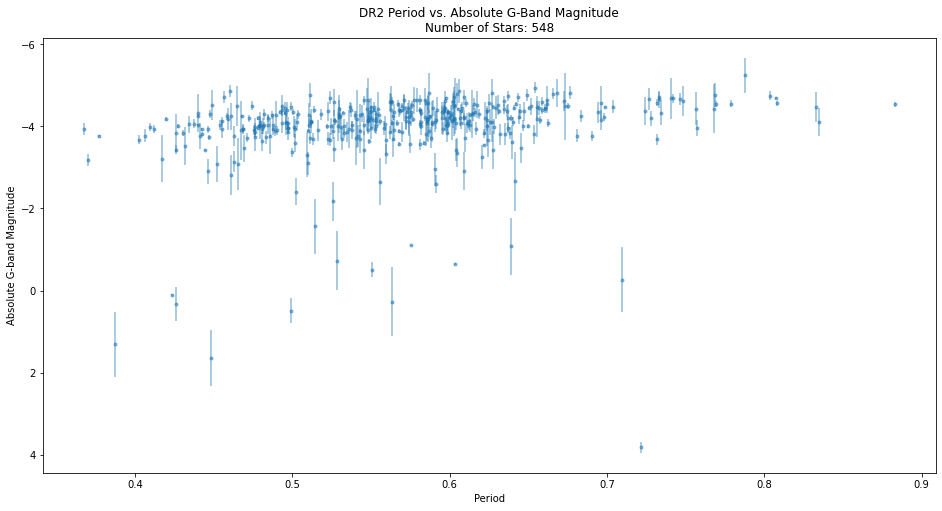

In [1032]:
gaia2_dists_df = rrlyrae_gaia2_filt.to_pandas()
gaia2_dists_df = gaia2_dists_df.assign(Mg = Mg, Mg_error = Mg_error)

plt.figure(figsize=(16,8))
plt.errorbar(gaia2_dists_df["pf"], gaia2_dists_df['Mg'], yerr=gaia2_dists_df['Mg_error'], alpha=0.5, fmt=".")
plt.ylim(plt.ylim()[::-1])
plt.xlabel("Period")
plt.ylabel("Absolute G-band Magnitude")
plt.title(f"DR2 Period vs. Absolute G-Band Magnitude\nNumber of Stars: {len(gaia3_dists_df)}")
plt.plot()

[]

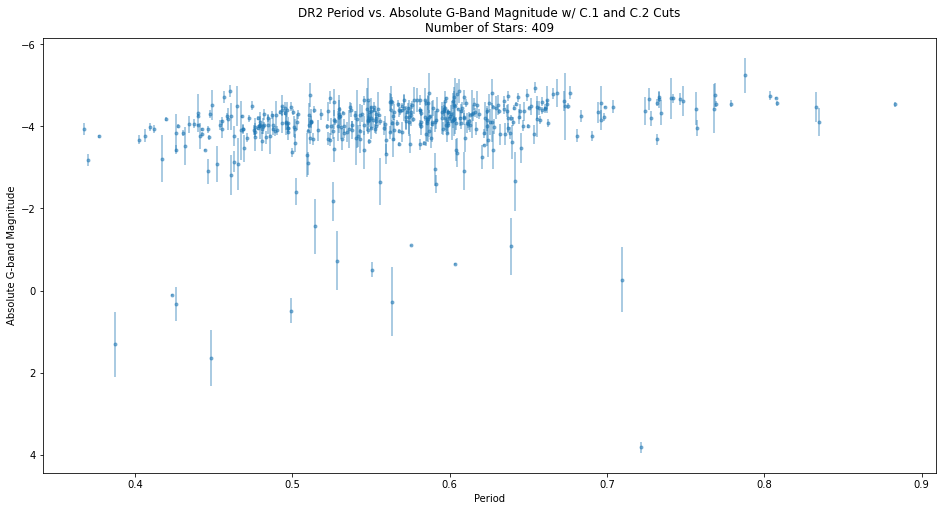

In [1031]:
u = np.sqrt(gaia2_dists_df['astrometric_chi2_al'] / (gaia2_dists_df['astrometric_n_good_obs_al'] - 5))
c1_rhs = 1.2*np.maximum(1, np.exp(-0.2*(gaia2_dists_df['Mg_error'] - 19.5)))
c1_mask = u < c1_rhs

c2_lhs = 1.0 + 0.015 * gaia2_dists_df['bp_rp']**2
c2_rhs = 1.3 + 0.06 * gaia2_dists_df['bp_rp']**2
e = gaia2_dists_df['phot_bp_rp_excess_factor']
c2_mask = (c2_lhs < e) & (c2_rhs > e)

gaia2_c1c2 = gaia2_dists_df[c1_mask & c2_mask]

plt.figure(figsize=(16,8))
plt.errorbar(gaia2_c1c2["pf"], gaia2_c1c2['Mg'], yerr=gaia2_c1c2['Mg_error'], alpha=0.5, fmt=".")
plt.ylim(plt.ylim()[::-1])
plt.xlabel("Period")
plt.ylabel("Absolute G-band Magnitude")
plt.title(f"DR2 Period vs. Absolute G-Band Magnitude w/ C.1 and C.2 Cuts\nNumber of Stars: {len(gaia2_c1c2)}")
plt.plot()

[]

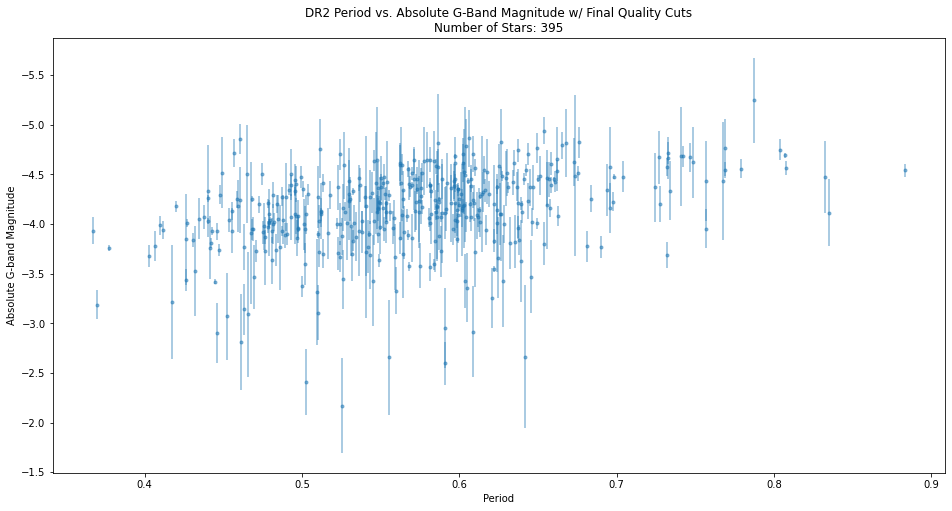

In [1033]:
thresh_mask = (gaia2_c1c2['Mg']<-2) & (gaia2_c1c2['Mg']>-6)
gaia2_qc = gaia2_c1c2[thresh_mask]
plt.figure(figsize=(16,8))
plt.errorbar(gaia2_qc["pf"], gaia2_qc['Mg'], yerr=gaia2_qc['Mg_error'], alpha=0.5, fmt=".")
plt.ylim(plt.ylim()[::-1])
plt.xlabel("Period")
plt.ylabel("Absolute G-band Magnitude")
plt.title(f"DR2 Period vs. Absolute G-Band Magnitude w/ Final Quality Cuts\nNumber of Stars: {len(gaia2_qc)}")
plt.plot()

# Q19

## (i)

In [672]:
def run_mh_mcmc(logprop_func, prop_func, prior_func=default_prior, size=1, steps=3000, chains=2):

    # initialize the first sample
    first = np.zeros((chains, size))
    
    # initialize tracking of states and acceptance rates
    states = np.zeros((chains, size, steps+1))
    acc_rates = np.zeros((chains, steps+1))
    num_acc = np.zeros(chains)
    
    #initialize for loop
    states[:,:,0] = first
    logprop_curr = logprop_func(first)
    
    for step in range(1, steps+1):
        
        state_curr = states[:,:,step-1]
        acc_rates[:,step] = acc_rates[:,step-1]
        
        #set the next state to the current state
        states[:,:,step] = state_curr
        
        prop = prop_func(states[:,:,step])
        logprop = logprop_func(prop) + prior_func(prop)
        # calculate acceptance ratio
        alpha = logprop_curr - logprop
        u = np.random.exponential(size=chains)
        
        mask = u > alpha
        states[mask,:,step] = prop[mask]
        logprop_curr[mask] = logprop[mask]
        num_acc[mask] += 1
        acc_rates[:, step] = num_acc/step
        
    return states, acc_rates

In [643]:
def gaussian_prop(s):
    def prop(state):
        return np.random.normal(state, s)
    return prop

def gaussian_logprop(mu, s):
    def logprop(state):
        return sp.stats.norm.logpdf(state[:,0], loc=mu, scale=s)
    return logprop

In [644]:
default_prior = lambda x: np.zeros(x.shape[0])

In [645]:
steps = 500
chains = 10
size = 1
logprop_func = gaussian_logprop(1,0.1)
prop_func = gaussian_prop(0.2)
states, acc_rates = run_mh_mcmc(logprop_func, prop_func, size = size, steps=steps, chains=chains)

In [646]:
acc_rates_flat.shape

(1001,)

[]

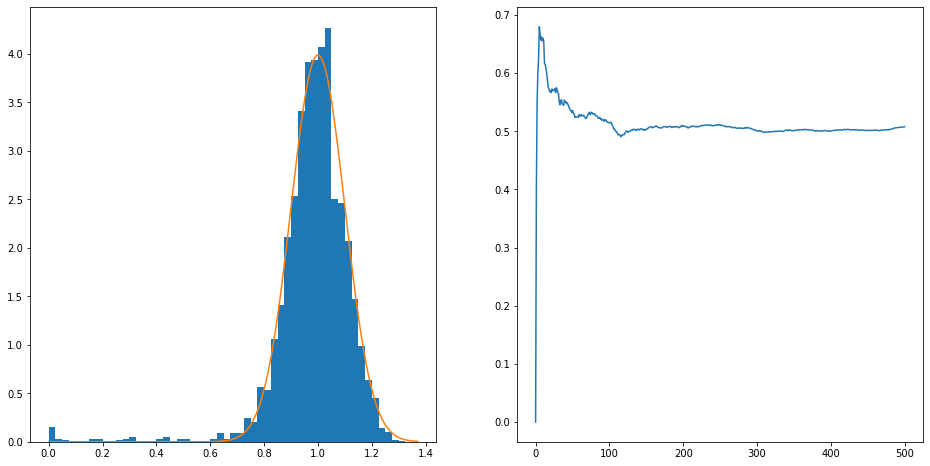

In [647]:
states_sample = states[:,:,:-50]
acc_rates_sample = acc_rates[:,:-50]
states_flat = states_sample.flatten()
acc_rates_flat = acc_rates.mean(axis=0).T
low = states_flat.min()
high = states_flat.max()
x = np.linspace(low, high, 1000)
y = sp.stats.norm.pdf(x, 1, 0.1)
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
ax1.hist(states.flatten(), bins=np.arange(low, high, 0.025), density=True)
ax1.plot(x,y)
ax2.plot(acc_rates_flat)
plt.plot()

In [732]:
7--13

20

In [739]:
def data_prior():
    def prior(state):
        a = state[:,0]
        b = state[:,1]
        logsig = state[:,2]
        a_pdf = sp.stats.uniform.pdf(a, loc=-13, scale = 7 - -13)
        b_pdf = sp.stats.uniform.pdf(b, loc=-11, scale = 9 - -11)
        logsig_pdf = sp.stats.uniform.pdf(logsig, loc=-10, scale = 10 - -10)
        return a_pdf*b_pdf*logsig_pdf
    return prior

In [914]:
def data_logproposal(x, y, yerr):
    x = np.array(x)
    y = np.array(y)
    yerr = np.array(yerr)
    def logprop(state):
#         print(f"State shape: {state.shape}")
        ab = state[:,:2]
        logsig = state[:,2]
        yhat = ab.dot(np.row_stack([np.log10(x),np.ones(x.shape)]))
        residuals = y - yhat
        
        big_sig = np.sqrt(np.add.outer(np.exp(logsig), np.power(yerr, 2)))
        
        logpdfs = sp.stats.norm.logpdf(residuals, loc=0, scale=big_sig)
        logsum = logpdfs.sum(axis=1)
        return logsum
    
    return logprop
        

In [915]:
np.random.seed(4938902)
logprop = data_logproposal(
    gaia3_qc['pf'],
    gaia3_qc['Mg'],
    gaia3_qc['Mg_error']
)
prop = gaussian_prop(0.05)
prior = data_prior()
steps = 10000
tune = 2000
chains = 10
size=3
states, acc_rates = run_mh_mcmc(logprop, prop, prior_func=prior, steps=steps, size=size, chains=chains)

<function matplotlib.pyplot.show(close=None, block=None)>

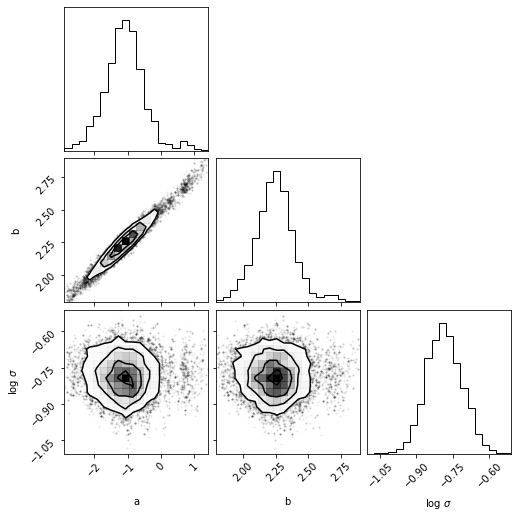

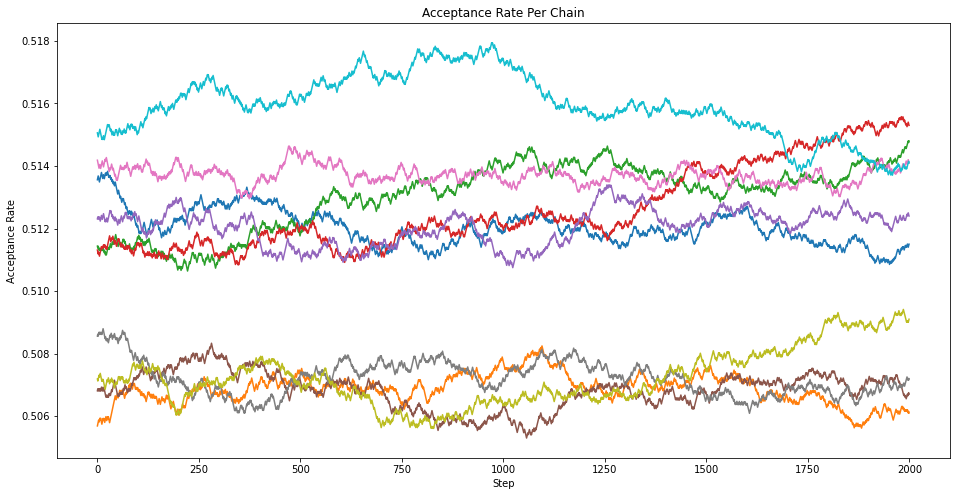

In [916]:
states = states[:,:,-tune:]
acc_rates = acc_rates[:,-tune:]
a_vals = states[:,0].reshape((-1,))
b_vals = states[:,1].reshape((-1,))
logsig_vals = states[:,2].reshape((-1,))
sig_vals = np.exp(logsig_est)
fig = corner(np.column_stack([ a_vals, b_vals, logsig_vals ]),
        labels = [ 'a', 'b', '$\\log\\ \\sigma$' ], color = 'k')

plt.figure(figsize=(16,8))
plt.plot(acc_rates.T)
plt.title("Acceptance Rate Per Chain")
plt.xlabel("Step")
plt.ylabel("Acceptance Rate")
plt.show

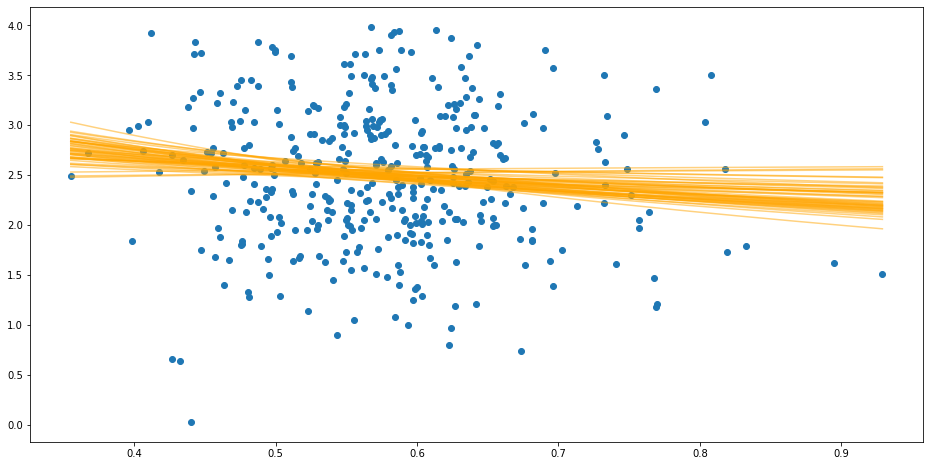

In [911]:
a = np.mean(a_vals,axis=0)
b = np.mean(b_vals, axis=0)
logsig = np.mean(logsig_vals, axis=0)
plt.figure(figsize=(16,8))
pf_range = np.linspace(np.min(gaia3_qc['pf']), np.max(gaia3_qc['pf']), 1000)
for samp in np.random.choice(len(a_vals), 50):
    a_samp = a_vals[samp]
    b_samp = b_vals[samp]
    logsig = logsig_vals[samp]
    plt.plot(pf_range, a_samp*np.log10(pf_range)+b_samp, c='orange', alpha=0.5)
plt.scatter(gaia3_qc['pf'], gaia3_qc['Mg'], label="Stars")


## (ii)

/home/rafferino/.local/lib/python3.6/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logsig, b, a]
INFO:pymc3:NUTS: [logsig, b, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
INFO:pymc3:Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
a      -0.876  0.373  -1.563   -0.168      0.014    0.010     685.0   685.0   
b       2.295  0.095   2.114    2.474      0.004    0.003     685.0   680.0   
logsig -0.813  0.055  -0.920   -0.717      0.002    0.001    1025.0  1025.0   

        ess_bulk  ess_tail  r_hat  
a          693.0     703.0    1.0  
b          693.0     740.0    1.0  
logsig    1030.0     905.0    1.0

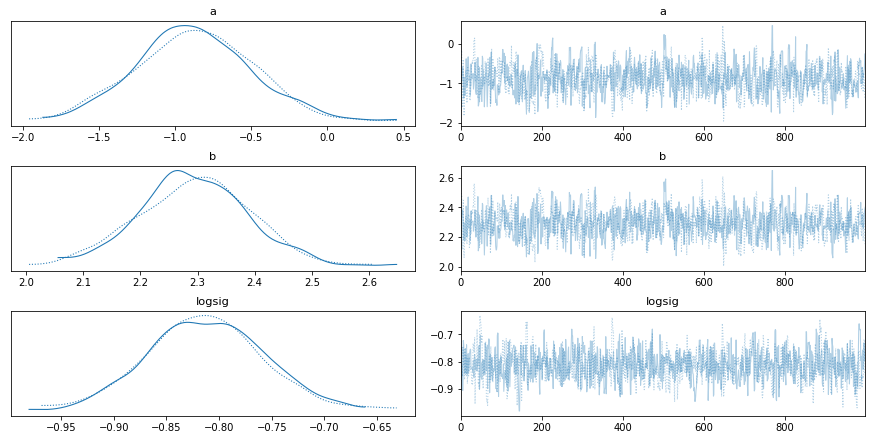

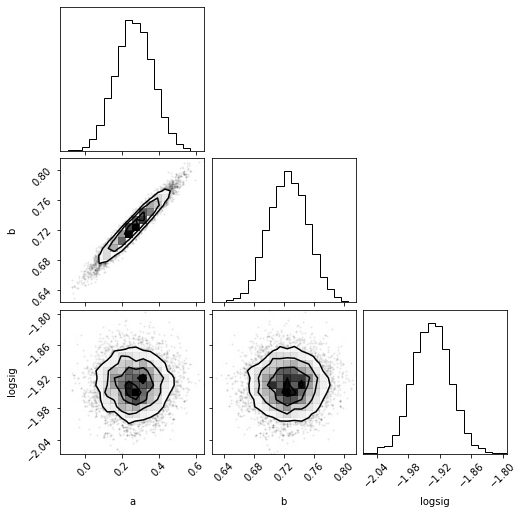

In [913]:
x,y,yerr = gaia3_qc['pf'],gaia3_qc['Mg'],gaia3_qc['Mg_error']
with pm.Model() as model:
    # define priors
    a = pm.Uniform("a", lower=-13, upper=7)
    b = pm.Uniform("b", lower=-11, upper=9)
    logsig = pm.Uniform("logsig", lower=-10, upper=10)

    sig_s = pm.math.exp(2*logsig)
    sig_i = yerr**2

    big_sig = np.sqrt(sig_s + sig_i)
    mu = a*np.log10(x)+b

    residual = np.array(y)-mu
    logpdfs = -np.log(big_sig) - residual**2/big_sig
    logsum = logpdfs.sum()
    
    pm.Potential('logp', logsum)

    # pm.sample will run the sampler and store output in 'trace' 
    trace = pm.sample(draws=1000, tune=1000, chains=2, cores=2)

    # traceplot is a routine for plotting the 'traces' from the samples
    _ = pm.traceplot(trace, var_names=["a", "b", "logsig"])

    # pm.summary provides some useful summary and convergance statistics
    display(pm.summary(trace, var_names=["a", "b", "logsig"]))
    # translate trace into pandas dataframe for plotting (you can also plot numpy arrays with corner)
    samples_ii = pm.trace_to_dataframe(trace, varnames=["a", "b", "logsig"])

    # make the corner plot and plot results from Hubble's paper as 'truth'
    # overplot percentiles: 16, 50, 84 on 1d historgrams
    corner(samples)

## (iii)

In [918]:
def run_mcmc(x, y, yerr, tune=1000, draws=4096):
    # set up the model
    with pm.Model() as model:

        # define priors
        a = pm.Uniform("a", lower=-13, upper=7)
        b = pm.Uniform("b", lower=-11, upper=9)
        logsig = pm.Uniform("logsig", lower=-10, upper=10)

        sig_s = pm.math.exp(logsig)
        sig_i = yerr**2
        
        big_sig = pm.math.sqrt(sig_s + sig_i)
        mu = a*pm.math.log(x)+b

        # define the log-likelihood function
        # note that numpy doesn't play nicely with PyMC3, so you should use their built in math functions
        pm.Normal("obs", mu = mu, sd=big_sig, observed=y)

        # now set up the model to run
        # default of PyMC3 is to use the no-turn sampler (NUTS)

        # pm.sample will run the sampler and store output in 'trace' 
        trace = pm.sample(draws=draws, tune=tune, chains=2, cores=2)

        # traceplot is a routine for plotting the 'traces' from the samples
        _ = pm.traceplot(trace, var_names=["a", "b", "logsig"])

        # pm.summary provides some useful summary and convergance statistics
        display(pm.summary(trace, var_names=["a", "b", "logsig"]))
        # translate trace into pandas dataframe for plotting (you can also plot numpy arrays with corner)
        samples = pm.trace_to_dataframe(trace, varnames=["a", "b", "logsig"])

        # make the corner plot and plot results from Hubble's paper as 'truth'
        # overplot percentiles: 16, 50, 84 on 1d historgrams
        corner(samples)
    return samples

/home/rafferino/.local/lib/python3.6/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logsig, b, a]
INFO:pymc3:NUTS: [logsig, b, a]


Sampling 2 chains for 5_000 tune and 4_096 draw iterations (10_000 + 8_192 draws total) took 16 seconds.
INFO:pymc3:Sampling 2 chains for 5_000 tune and 4_096 draw iterations (10_000 + 8_192 draws total) took 16 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
a      -0.395  0.243  -0.849    0.060      0.005    0.003    2831.0  2541.0   
b       2.284  0.141   2.018    2.546      0.003    0.002    2840.0  2840.0   
logsig -0.788  0.075  -0.924   -0.649      0.001    0.001    4037.0  4023.0   

        ess_bulk  ess_tail  r_hat  
a         2834.0    3221.0    1.0  
b         2842.0    2872.0    1.0  
logsig    4016.0    3676.0    1.0

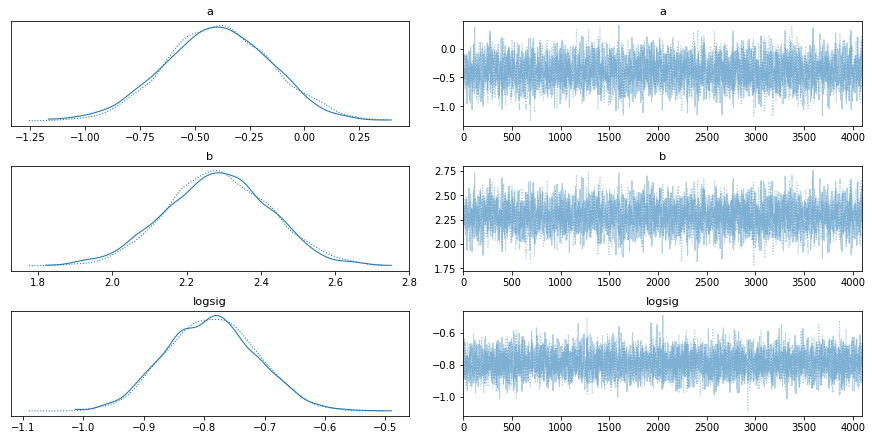

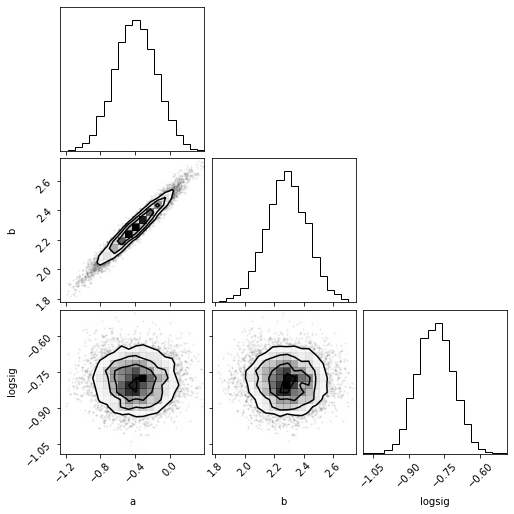

In [919]:
x,y,yerr = gaia3_qc['pf'],gaia3_qc['Mg'],gaia3_qc['Mg_error']
samples_iii = run_mcmc(x, y, yerr, tune=5000, draws=4096)

In [896]:
a_est, b_est, logsig_est = np.mean(samples_iii, axis=0)
print(a_est, b_est)

-0.9041225370573316 2.2856694746498025


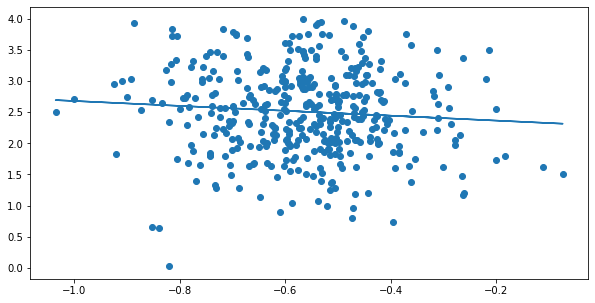

In [921]:
plt.figure(figsize=(10,5))
plt.scatter(np.log(gaia3_qc["pf"]), gaia3_qc["Mg"])
plt.plot(np.log(gaia3_qc["pf"]), a_est*np.log10(gaia3_qc["pf"])+b_est)
plt.show()

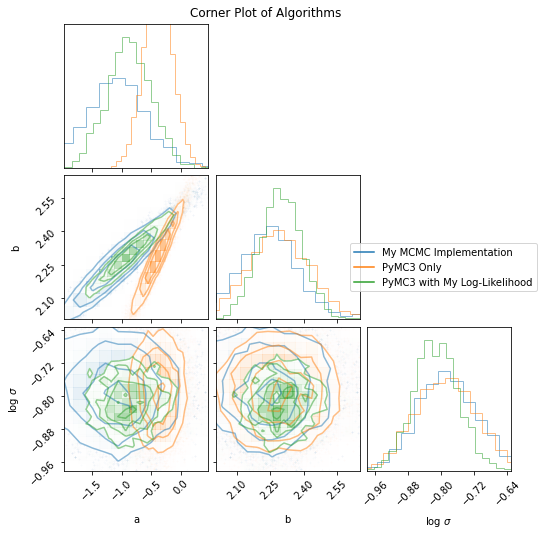

In [920]:
bins = 20
alpha_color = 0.5
alpha_speck = 0.02

fig = corner(np.column_stack([ a_vals, b_vals, logsig_vals ]),
        bins = bins, color = colors.to_rgb('C0') + ( alpha_color, ),
        data_kwargs = { 'alpha': alpha_speck }, hist_kwargs = { 'density': True })
l0 = lines.Line2D([], [], color = 'C0', label = 'My MCMC Implementation')

fig = corner(np.column_stack([ samples_iii['a'], samples_iii['b'], samples_iii['logsig'] ]),
        bins = bins, color = colors.to_rgb('C1') + ( alpha_color, ),
        data_kwargs = { 'alpha': alpha_speck }, hist_kwargs = { 'density': True },
        labels = [ 'a', 'b', '$\\log\\ \\sigma$' ],
        fig = fig)
l1 = lines.Line2D([], [], color = 'C1', label = 'PyMC3 Only')

fig = corner(np.column_stack([ samples_ii['a'], samples_ii['b'], samples_ii['logsig'] ]),
        bins = bins, color = colors.to_rgb('C2') + ( alpha_color, ),
        data_kwargs = { 'alpha': alpha_speck }, hist_kwargs = { 'density': True },
        fig = fig)
l2 = lines.Line2D([], [], color = 'C2', label = 'PyMC3 with My Log-Likelihood')

fig.suptitle('Corner Plot of Algorithms')
fig.legend(handles = [ l0, l1, l2 ], loc = 'center right')
pass

# Q20

In [55]:
query = f"""
    SELECT *
    FROM gaiaedr3.gaia_source as gaia
    JOIN gaiaedr3.dr2_neighbourhood as link
        ON gaia.source_id = link.dr3_source_id
    JOIN gaiadr2.vari_rrlyrae as lyrae
        ON lyrae.source_id = link.dr2_source_id
    JOIN gaiadr2.allwise_best_neighbour as wise_link
        ON wise_link.source_id = link.dr2_source_id
    JOIN gaiadr1.allwise_original_valid as wise
        ON wise.allwise_oid = wise_link.allwise_oid
    WHERE 
        parallax_over_error > 5
        AND abs(b) > 30
        AND parallax > 0.25
        AND pf IS NOT NULL
        AND astrometric_excess_noise < 1
        AND 1 + 0.015*power(bp_rp, 2) < phot_bp_rp_excess_factor
        AND phot_bp_rp_excess_factor < 1.3 + 0.06*power(bp_rp, 2)
"""
rrlyrae_wise_gaia3 = get_gaia_query_general_cached(query)
rrlyrae_wise_gaia3[:10]

<Table length=10>
    solution_id              designation          ... w4gmag_error tmass_key 
                                                  ...     mag                
       int64                    object            ...   float64      int64   
------------------- ----------------------------- ... ------------ ----------
1636042515805110273 Gaia EDR3 4685757887726594816 ...           --   52227476
1636042515805110273 Gaia EDR3 4793950312913699328 ...           --  718434934
1636042515805110273 Gaia EDR3 6271733007667343360 ...           --  338101052
1636042515805110273 Gaia EDR3 6275283468151655424 ...           --   31096150
1636042515805110273 Gaia EDR3 6321036891467501952 ...           --  316106569
1636042515805110273 Gaia EDR3 6327036861995922560 ...           --  311891066
1636042515805110273 Gaia EDR3 6189279973568784384 ...           --  326817216
1636042515805110273 Gaia EDR3 1481133009762718720 ...           --  218925224
1636042515805110273 Gaia EDR3 6190268571961010944 ...           --  322044891
1636042515805110273 Gaia EDR3 6308159961037880576 ...           -- 1276858090

[]

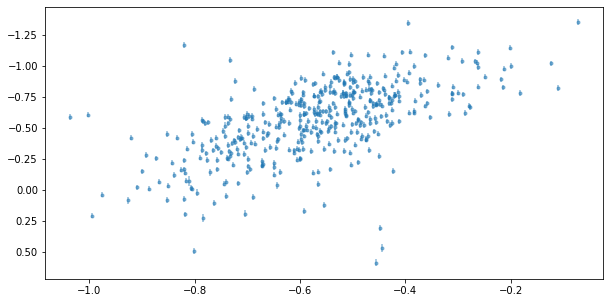

In [967]:
gaia3_wise = rrlyrae_wise_gaia3.to_pandas()
w2mpro_Mg = gaia3_wise["w2mpro"] + 5*np.log10(gaia3_wise['parallax']) - 10
gaia3_wise = gaia3_wise.assign(w2mpro_Mg = w2mpro_Mg)
gaia3_wise_qc = gaia3_wise[gaia3_wise['w2mpro_Mg']<1.8]
plt.figure(figsize=(10,5))
plt.errorbar(np.log(gaia3_wise_qc["pf"]), gaia3_wise_qc["w2mpro_Mg"], yerr=gaia3_wise_qc["w2mpro_error"], fmt=".", alpha=0.5)
plt.ylim(plt.ylim()[::-1])
plt.plot()

# Q21

/home/rafferino/.local/lib/python3.6/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logsig, b, a]
INFO:pymc3:NUTS: [logsig, b, a]


Sampling 2 chains for 5_000 tune and 4_096 draw iterations (10_000 + 8_192 draws total) took 15 seconds.
INFO:pymc3:Sampling 2 chains for 5_000 tune and 4_096 draw iterations (10_000 + 8_192 draws total) took 15 seconds.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
a      -2.695  0.170  -2.993   -2.358      0.003    0.002    3410.0  3402.0   
b      -1.227  0.043  -1.306   -1.143      0.001    0.001    3460.0  3460.0   
logsig -1.453  0.035  -1.516   -1.386      0.001    0.000    4239.0  4234.0   

        ess_bulk  ess_tail  r_hat  
a         3412.0    3319.0    1.0  
b         3467.0    3299.0    1.0  
logsig    4248.0    3785.0    1.0

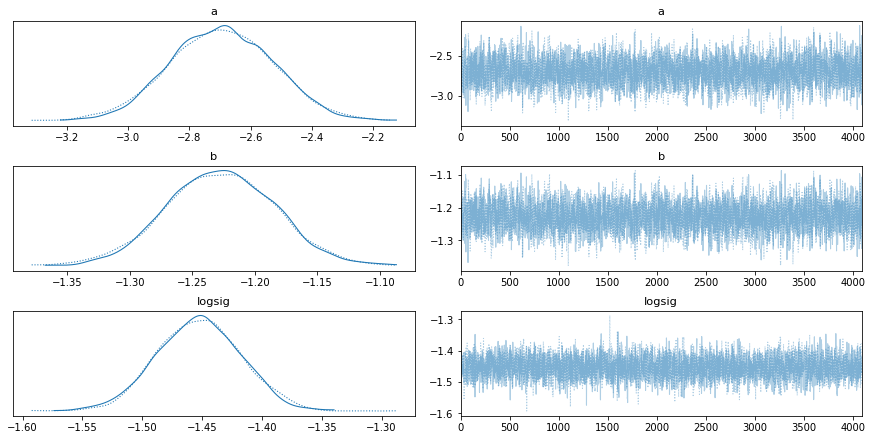

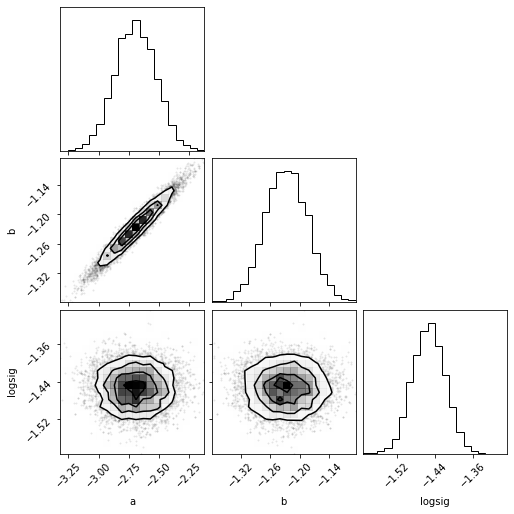

In [970]:
y = gaia3_wise_qc["w2mpro_Mg"]
x = gaia3_wise_qc['pf']
yerr = gaia3_wise_qc["w2mpro_error"]

with pm.Model() as model:

    # define priors
    a = pm.Normal("a", mu=0, sigma=10)
    b = pm.Normal("b", mu=0, sigma=10)
    logsig = pm.Normal("logsig", mu=0, sigma=5)

    sig_s = pm.math.exp(2*logsig)
    sig_i = yerr**2
    big_sig = pm.math.sqrt(sig_s + sig_i)
    
    mu = a*np.log10(x)+b
    pm.Normal("obs", mu = mu, sd=big_sig, observed=y)

    # pm.sample will run the sampler and store output in 'trace' 
    trace = pm.sample(draws=4096, tune=5000, chains=2, cores=2)

    # traceplot is a routine for plotting the 'traces' from the samples
    _ = pm.traceplot(trace, var_names=["a", "b", "logsig"])

    # pm.summary provides some useful summary and convergance statistics
    display(pm.summary(trace, var_names=["a", "b", "logsig"]))
    # translate trace into pandas dataframe for plotting (you can also plot numpy arrays with corner)
    samples_w2 = pm.trace_to_dataframe(trace, varnames=["a", "b", "logsig"])
    corner(samples_w2)
    plt.plot()

-2.695281160818483 -1.2274031966987815


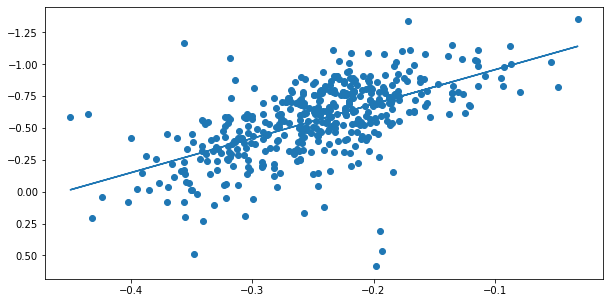

In [974]:
a_w2, b_w2, logsig_w2 = np.mean(samples_w2, axis=0)
print(a_w2, b_w2)
plt.figure(figsize=(10,5))
plt.scatter(np.log10(x), y)
plt.plot(np.log10(x), a_w2*np.log10(x)+b_w2)
plt.ylim(plt.ylim()[::-1])
plt.show()

# Q22

In [980]:
print(np.exp(samples_iii['logsig'].mean()))
print(np.exp(logsig_w2))

0.45459771257456033
0.23392614981060647


The relationship is stronger for the **W2-band** at $\hat{a} = -2.695$ compared to that of the **G-Band** at $\hat{a} = -0.3954$

The offset is different for the **W2-band** at $\hat{b} = -1.227$ compared to that of the **G-Band** at $\hat{b} = 2.2842$

The spread for the **W2-band** $\hat{\sigma} = 0.2339$ is nearly half that of the **G-Band** $\hat{\sigma} = 0.45459$

# Q23

Using Klein & Bloom models:
* `M_V  =  0.4319 - 0.4091 log10(P)`
* `M_W2 = -0.4583 - 2.2337 log10(P)`

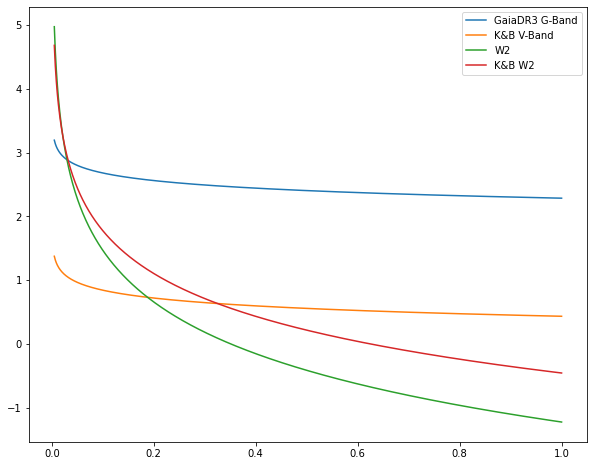

In [972]:
pf_range = np.linspace(0.005,1, 1000)
predict = lambda x, a, b: a*np.log10(x) + b
y_Mg = predict(pf_range, samples_iii['a'].mean(), samples_iii['b'].mean())
y_w2 = predict(pf_range, samples_w2['a'].mean(), samples_w2['b'].mean())
y_v_kb = predict(pf_range, -0.4091, 0.4319)
y_w2_kb = predict(pf_range, -2.2337, -0.4583)

plt.figure(figsize=(10,8))
plt.plot(pf_range, y_Mg, label="GaiaDR3 G-Band")
plt.plot(pf_range, y_v_kb, label="K&B V-Band")
plt.plot(pf_range, y_w2, label="W2")
plt.plot(pf_range, y_w2_kb, label="K&B W2")
plt.legend()
plt.show()

As expected, the G-Band and V-Band are very similar, however they are offset by some value between my approximation of the coefficients and Klein & Bloom model. This makes sense as these two bands are similar but different. While the source of study of my W2 approximation and the Klein & Bloom approximation are also very similar, the difference between the two can be explained by a number of factors. Firstly, Klein & Bloom didn't have the GAIA database, so the stars used to construct the data, as well as the data on stars that may overlap are probably different. Furthermore, there is probably a difference in the quality cuts on the relevant stars.

It is interesting to note that it is possible to tell which curve matches which (between my approximations and the Klein & Bloom paper) can be discerned just from looking at the shape of the curves.

# Q24

/home/rafferino/.local/lib/python3.6/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logsig, b, a]
INFO:pymc3:NUTS: [logsig, b, a]


Sampling 2 chains for 5_000 tune and 4_096 draw iterations (10_000 + 8_192 draws total) took 16 seconds.
INFO:pymc3:Sampling 2 chains for 5_000 tune and 4_096 draw iterations (10_000 + 8_192 draws total) took 16 seconds.
The acceptance probability does not match the target. It is 0.8848456726240563, but should be close to 0.8. Try to increase the number of tuning steps.


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
a       0.117  0.046   0.033    0.204      0.001    0.001    3077.0  2875.0   
b       0.726  0.027   0.676    0.777      0.000    0.000    3093.0  3080.0   
logsig -3.869  0.069  -4.002   -3.743      0.001    0.001    3435.0  3435.0   

        ess_bulk  ess_tail  r_hat  
a         3088.0    2709.0    1.0  
b         3103.0    2560.0    1.0  
logsig    3395.0    3185.0    1.0

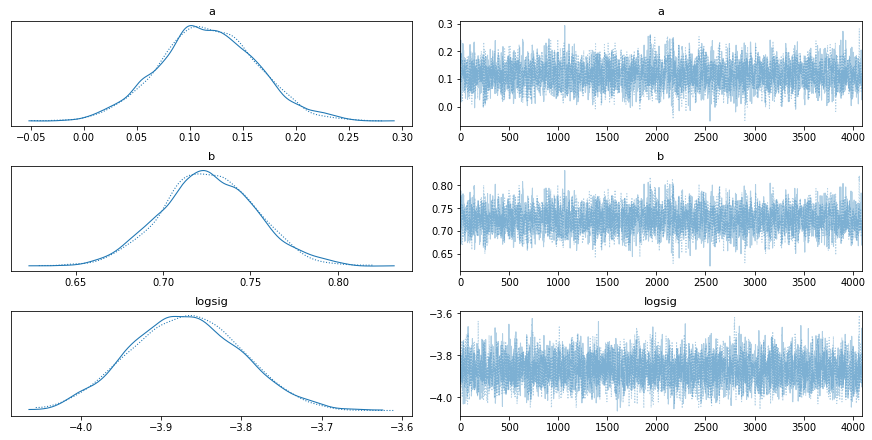

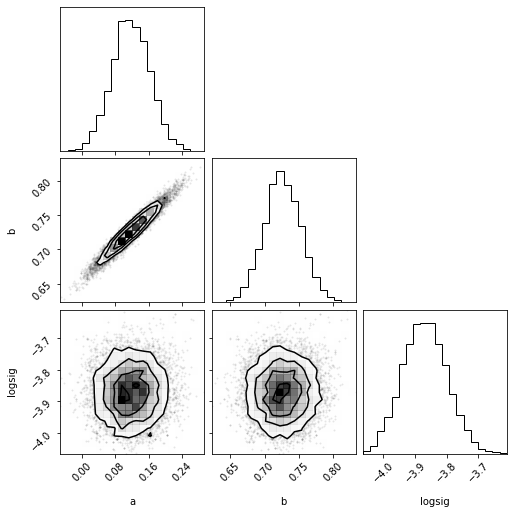

In [983]:
y = rrlyrae_wise_gaia3["bp_rp"]
x = rrlyrae_wise_gaia3['pf']
yerr = 1.09/np.sqrt(rrlyrae_wise_gaia3["phot_bp_mean_flux_over_error"]**2 + rrlyrae_wise_gaia3["phot_rp_mean_flux_over_error"]**2)
samples_bprp = run_mcmc(x, y, yerr, tune=5000)

-0.9041225370573316 2.2856694746498025


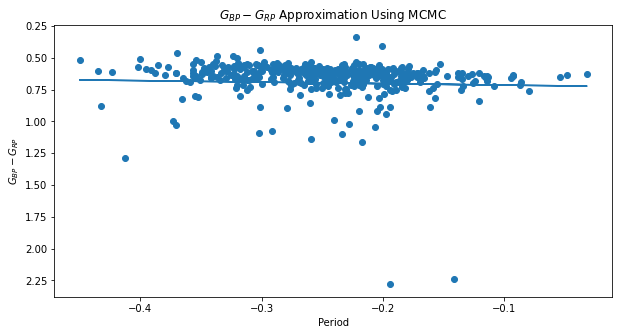

In [985]:
a_bprp, b_bprp, logsig_bprp = np.mean(samples_bprp, axis=0)
print(a_est, b_est)
plt.figure(figsize=(10,5))
plt.scatter(np.log10(x), y)
plt.plot(np.log10(x), a_bprp*np.log10(x)+b_bprp)
plt.title("$G_{BP} - G_{RP}$ Approximation Using MCMC")
plt.ylabel("$G_{BP} - G_{RP}$")
plt.xlabel("Period")
plt.ylim(plt.ylim()[::-1])
plt.show()

# Q25

In [828]:
query = f"""
    SELECT *
    FROM gaiaedr3.gaia_source as gaia
    JOIN gaiaedr3.dr2_neighbourhood as link
        ON gaia.source_id = link.dr3_source_id
    JOIN gaiadr2.vari_rrlyrae as lyrae
        ON lyrae.source_id = link.dr2_source_id
    WHERE
        pf IS NOT NULL
"""
rrlyrae_all = get_gaia_query_general_cached(query)
rrlyrae_all[:10]

<Table length=10>
    solution_id              designation          ... best_classification
                                                  ...                    
       int64                    object            ...        object      
------------------- ----------------------------- ... -------------------
1636042515805110273 Gaia EDR3 5884553250832851200 ...                RRab
1636042515805110273 Gaia EDR3 5870760633362254848 ...                RRab
1636042515805110273 Gaia EDR3 5865284545760288512 ...                RRab
1636042515805110273 Gaia EDR3 5865347428404130560 ...                RRab
1636042515805110273 Gaia EDR3 5865198410283237632 ...                RRab
1636042515805110273 Gaia EDR3 5865198410283237760 ...                RRab
1636042515805110273 Gaia EDR3 5877954085112175488 ...                RRab
1636042515805110273 Gaia EDR3 5877954085128759296 ...                RRab
1636042515805110273 Gaia EDR3 5877954085112175616 ...                RRab
1636042515805110273 Gaia EDR3 5879361185109392896 ...                RRab

# Q26

In [829]:
bprp_int = a_est*np.log(rrlyrae_all["pf"])+b_est
bprp_obs = rrlyrae_all["bp_rp"]
col_exc = bprp_obs - bprp_int

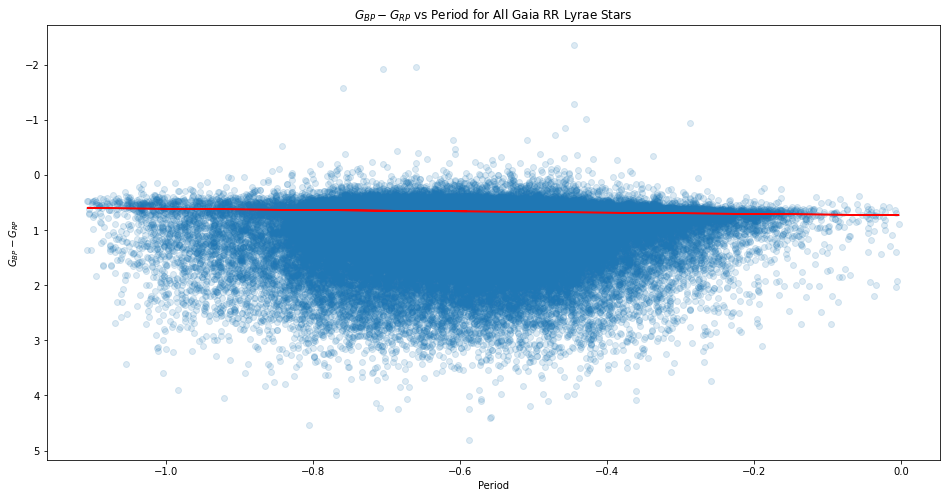

In [981]:
plt.figure(figsize=(16,8))
plt.scatter(np.log(rrlyrae_all["pf"]), bprp_obs, alpha=0.15)
plt.plot(np.log(rrlyrae_all["pf"]), bprp_int, c="red")
plt.ylim(plt.ylim()[::-1])
plt.title("$G_{BP} - G_{RP}$ vs Period for All Gaia RR Lyrae Stars")
plt.xlabel("Period")
plt.ylabel("$G_{BP} - G_{RP}$")
plt.show()

# Q27

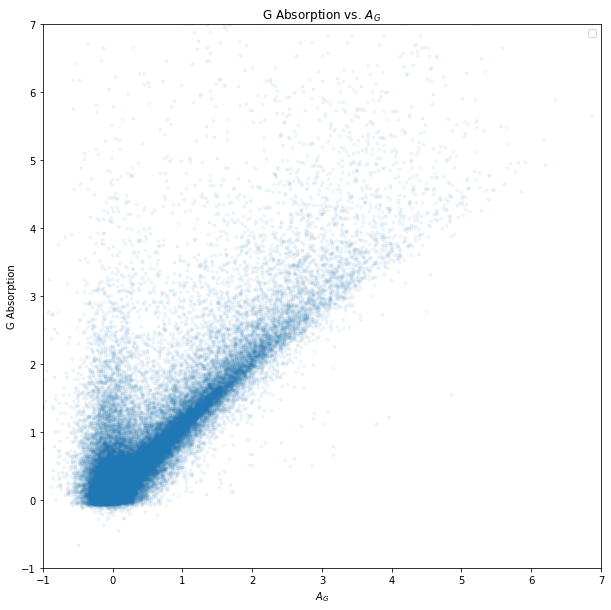

In [955]:
Ag = 2*col_exc
g_abso = rrlyrae_all['g_absorption']
plt.figure(figsize=(10,10))
plt.scatter(Ag, g_abso, alpha=0.05, marker=".")
plt.ylim((-1,7))
plt.xlim((-1,7))
plt.xlabel("$A_G$")
plt.ylabel("G Absorption")
plt.title("G Absorption vs. $A_G$")
plt.legend()

It seems like a lot of the stars correlate, but there seems to be a lot in both calculations, $A_G$ and G Absorption that are around 0. Furthermore, there are a few stars off the limits of this chart, although it is hard to say whether they are outliers. This can probably be fixed with more filtering. 

# Q28

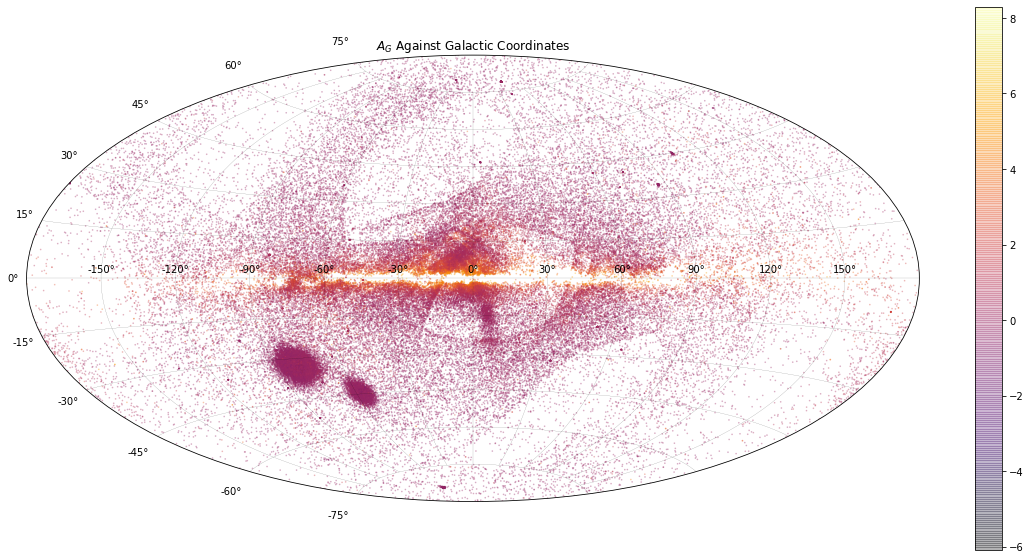

In [998]:
lon = np.radians(np.mod(180+rrlyrae_all['l'], 360) - 180)
lat = np.radians(rrlyrae_all['b'])
plt.figure(figsize=(20,10))
plt.subplot(1,1,1,projection='aitoff')
plt.scatter(lon, lat, c=Ag, alpha=0.3, s=0.5, cmap='inferno')
plt.grid(c='k',linewidth=0.1)
plt.title("$A_G$ Against Galactic Coordinates")
plt.colorbar()
plt.show()

The distribution of RR Lyrae stars is not at all uniform. There is probably a number of reasons for this. Firstly, GAIA most likely focuses on specific star clusters or interesting areas in the sky rather than attempting to obtain a uniform coverage. This is probably evident in the densely populated region at around (-30, -60). Secondly, stars that are further away are less likely to be picked up due to the affects of dust or the luminosity of other celestial bodies. This is most evident in the sparse edges of the diagram. Lastly, the stars themselves are not evenly distributed.

There doesn't seem to be too many stars with wildly different $A_G$ values than their neighbors, so quality cuts may not be necessary.

# Q29

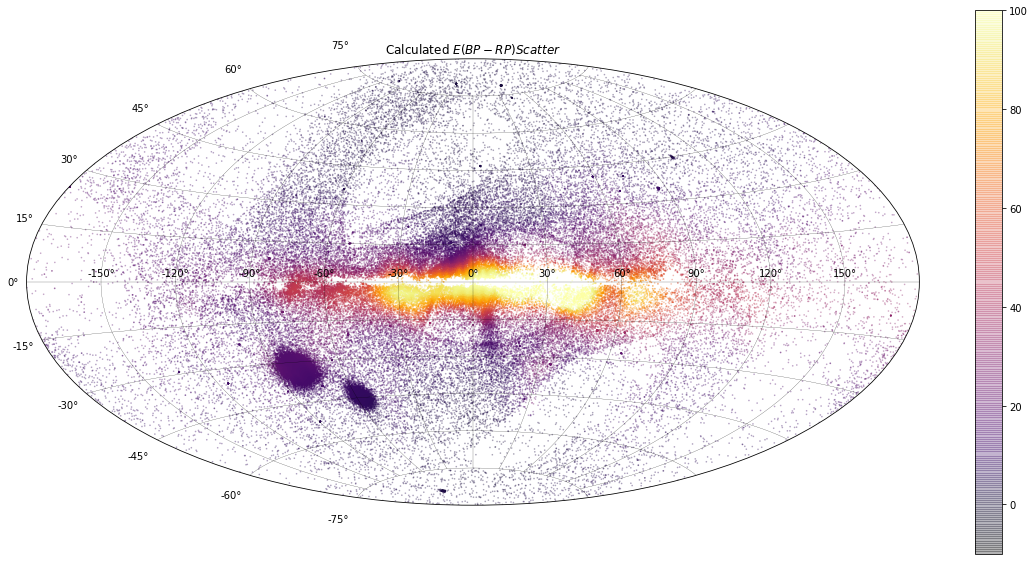

In [999]:
sfd = SFDQuery()

rr_coords = SkyCoord(lon, lat, unit = 'rad', frame = 'galactic')
sfd_data = sfd(rr_coords)

plt.figure(figsize = (20, 10), facecolor = 'w')

# scatter
plt.subplot(1, 1, 1, projection = 'aitoff')
plt.title('Calculated $E(BP-RP) Scatter$')
plt.scatter(lon, lat, c = sfd_data, cmap = 'inferno', s = 0.5, alpha = 0.3, vmin=-10, vmax=100)
plt.grid(c = 'k', linewidth = 0.2)
plt.colorbar()
plt.show()

The overall structure of the SFD plot matches my plot, however it does seem like many quality cuts were made to construct this data. This is most evident at the origin (0,0) where the colors don't QUITE match up. Furthermore, the scales are completely different and it seems as if my plot was constructed using log data or on some scale that I am unfamiliar with.

# Q30

I didn't expect the SFD plot to look anything like my plot, so I was quite surprised that the data I queried and calculated matched up quite nicely. Differences in approaches to the calculation of such a map - such as quality cuts, different calculations, $E(B-V)$ vs. $A_G$, and so forth - definitely make the SFD map a thing to behold.